In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
import yaml
matplotlib.rcParams.update({'font.size': 18})
from pathlib import Path
import gc
import shutil
import h5py

/export/home/wjoran/miniconda3/envs/py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import fff
from torchvision.datasets import EMNIST
from torchvision.transforms.v2 import ToImage, ToDtype, Resize, Compose, CenterCrop, Grayscale, ToPILImage, ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image, ImageFilter
import lightning_trainable

In [3]:
def plot_images_28(data, n_rows=2, n_columns=9, save=False, plot_dir="demo"):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_columns):
            axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

In [4]:
# To load it back:
with h5py.File('/export/data/wjoran/FFF/data/cc_mnist/data.h5', 'r') as f:
    Xtr = torch.from_numpy(f['train_images'][:])
    ztr = torch.from_numpy(f['train_z'][:])
    Xt = torch.from_numpy(f['test_images'][:])
    zt = torch.from_numpy(f['test_z'][:])

In [4]:
def sample_Gaussian_mixture(N,fraction1=0.6,fraction2=0.35, centers_i=0):
    rand = torch.rand(N)
    n_1 = rand[rand<fraction1].shape[0]
    n_2 = rand[rand>(1-fraction2)].shape[0]
    n_3 = N-n_1-n_2
    n = [n_1, n_2, n_3]
    scales = [0.08, 0.015, 0.02]
    centers = [0.3, 0.5, 0.9]
    samples = torch.Tensor([])
    for i in range(3):
        if n[i]>0:
            samples = torch.clamp(
                1-((torch.cat([samples, torch.randn(n[i]) * scales[i] + centers[i]]))%1),
                min=0, max=1.)
        
    perm = torch.randperm(N)
    samples = samples[perm]
    return samples

In [5]:
def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma

In [6]:
def gaussian_mix_dense_b(x):
    return 0.6 * normal(x, 0.6, 0.08) + 0.35 * normal(x, 0.35, 0.015) + 0.1 * normal(x, 0., 0.02)
def gaussian_mix_dense_d(x):
    return 0.02 * normal(x, 0.05, 0.02) + 0.53 * normal(x, 0.88, 0.015) + 0.45 * normal(x, 0.45, 0.04)

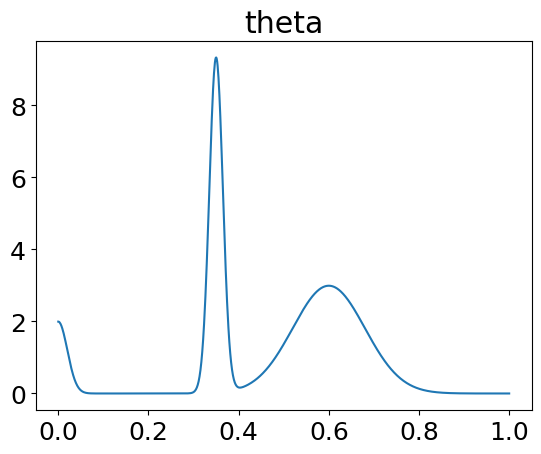

In [7]:
x = np.linspace(0,1,1000)
plt.plot(x, gaussian_mix_dense_b(x))
#plt.plot(1-x, gaussian_mix_dense_b(x))
plt.title("theta")
plt.show()

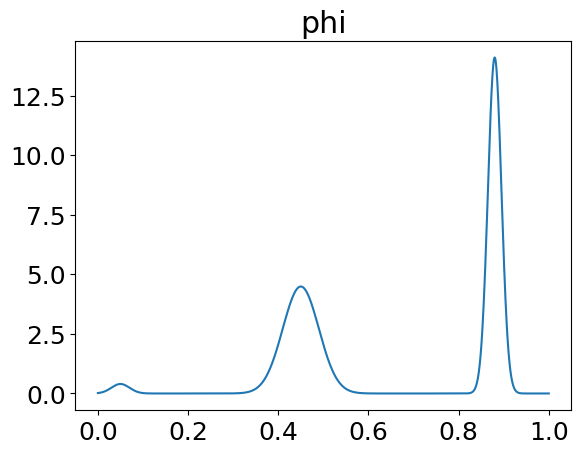

In [8]:
plt.plot(x, gaussian_mix_dense_d(x))
plt.title("phi")
plt.show()

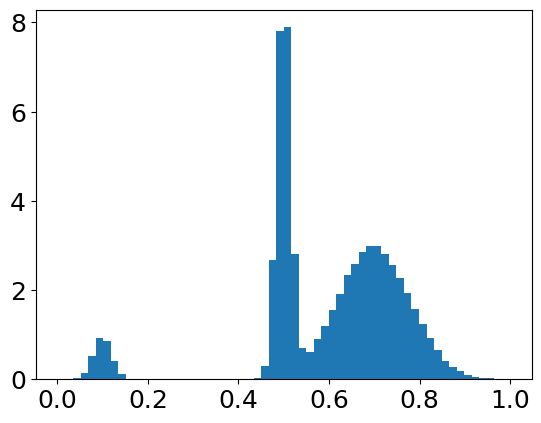

In [9]:
dof_t = []
for i in range(3):
    dof_t.append(sample_Gaussian_mixture(5*40000))
plt.hist(dof_t[0], bins=60, density=True)
plt.show()

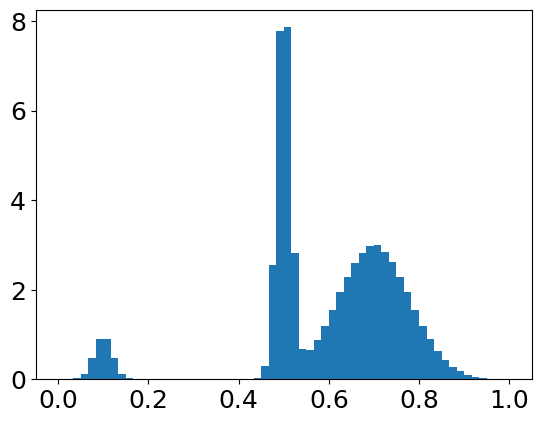

In [10]:
dof_tr = []
for i in range(3):
    dof_tr.append(sample_Gaussian_mixture(5*240000))
plt.hist(dof_tr[0], bins=60, density=True)
plt.show()

In [12]:
def max1_mnist(x_data):
    x_data = x_data - torch.min(x_data.reshape(-1,28*28),-1)[0].unsqueeze(1).unsqueeze(1).expand(-1,28,28)
    max = torch.max(x_data.reshape(-1,28*28),-1)[0]
    print(max[max!=255])
    x_data = x_data / torch.max(x_data.reshape(-1,28*28),-1)[0].unsqueeze(1).unsqueeze(1).expand(-1,28,28)
    return x_data

torch.Size([240000, 28, 28])
torch.Size([1200000, 3, 28, 28])
Colorized MNIST samples:


/tmp/ipykernel_1282841/3243386645.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)


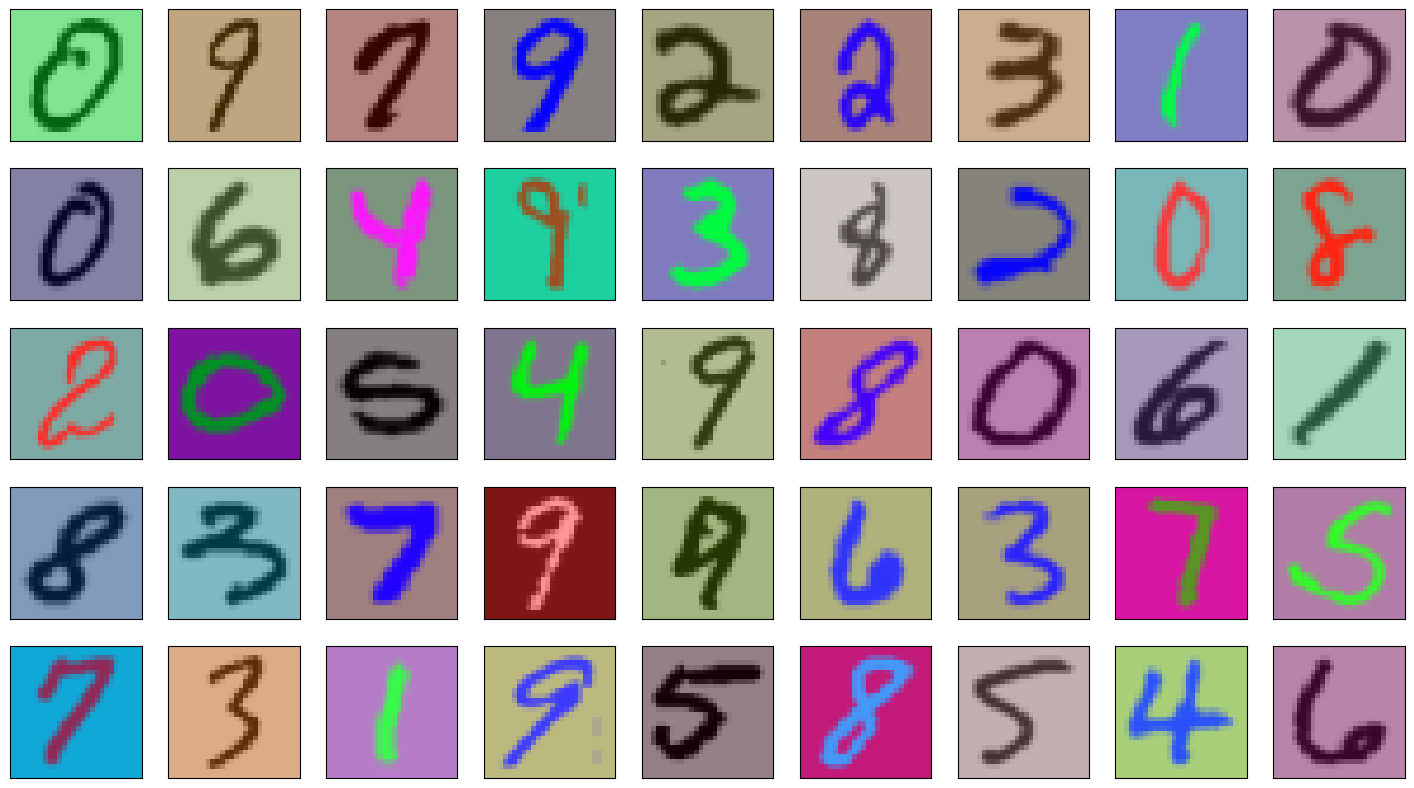

In [14]:
"""
def colorize_mnist(x_data, dof):
    theta = (1-dof[0])*torch.pi/2
    phi = dof[1]*torch.pi/2
    r = torch.sin(theta) * torch.cos(phi)
    g = torch.sin(theta) * torch.sin(phi)
    b = torch.cos(theta)
    b_colors = [r,g,b]
    norm = r**2+g**2+b**2
    r = torch.sin(theta + torch.pi/2) * torch.cos(phi)
    g = torch.sin(theta + torch.pi/2) * torch.sin(phi)
    b = torch.cos(theta + torch.pi/2)
    f_colors = [r,g,b]
    norm = r**2+g**2+b**2
    print(norm[:10])
    y = torch.zeros((x_data.shape[0], 28, 28))
    y[:, 14:,14:] = dof[3].unsqueeze(1).unsqueeze(1).expand(-1,14,14)
    y[:, :14,14:] = dof[4].unsqueeze(1).unsqueeze(1).expand(-1,14,14)
    for i in range(3):
        b_colors[i] = b_colors[i].unsqueeze(1).unsqueeze(1).expand(-1,28,28)
        f_colors[i] = f_colors[i].unsqueeze(1).unsqueeze(1).expand(-1,28,28)
    # Normalize pixel values to 0-1 for easier masking
    x_data_normalized = x_data / 255.0

    # Create the RGB image stack
    colorized_images = torch.zeros((x_data.shape[0], 28, 28, 3))

    print(torch.argmax(x_data_normalized.reshape(-1,28*28),-1)[:10])
    #test = torch.zeros((x_data.shape[0], 28, 28, 3))
    for c in range(3):  # Assigning each RGB channel
        colorized_images[..., c] = (
            1/3 * (1 - x_data_normalized) * b_colors[c]
            #+ 2/3 * y * f_colors[c]
        )
        
        #test[:,:,:,c] = (colorized_images[..., c] - b_colors[c])**2
    #print(torch.argmax(torch.sum(test,-1).reshape(-1,28*28),-1)[:10])

    return colorized_images
"""
def colorize_mnist(x_data, dof):
    r = list(torch.split(dof[0], x_data.shape[0]))
    g = list(torch.split(dof[1], x_data.shape[0]))
    b = list(torch.split(dof[2], x_data.shape[0]))
    b_colors = [r,g,b]
    for c in range(3):
        for i in range(5):
            b_colors[c][i] = b_colors[c][i].unsqueeze(1).unsqueeze(1).expand(-1,28,28)
    # Normalize pixel values to 0-1 for easier masking
    x_data_normalized = x_data / 255.0

    colorized_images = []

    for i in range(5):
        # Create the RGB image stack
        colorized_images_i = torch.zeros((x_data.shape[0], 28, 28, 3))
        for c in range(3):  # Assigning each RGB channel
            colorized_images_i[..., c] = (
                (1 - x_data_normalized) * b_colors[c][i] + x_data_normalized * ((b_colors[c][i]+0.5)%1)
                #+ 2/3 * y * f_colors[c]
            )
        colorized_images.append(colorized_images_i)
    colorized_images = torch.cat(colorized_images,0)

    return colorized_images

# Load the MNIST dataset
train_dataset = EMNIST(root="data", train=True, split="digits")
test_dataset = EMNIST(root="data", train=False, split="digits")
x_test = test_dataset.data
x_train = train_dataset.data
print(x_train.shape)

# Apply colorization
colorized_train = colorize_mnist(x_train, dof_tr).permute(0,3,1,2)

#colorized_test = colorize_mnist(x_test[0].unsqueeze(0).repeat(x_test.shape[0],1,1), dof_t).permute(0,3,1,2)
colorized_test = colorize_mnist(x_test, dof_t).permute(0,3,1,2)

print(colorized_train.shape)
print("Colorized MNIST samples:")
#display_images(colorized_train)
plot_images_28(colorized_test, n_rows=5)

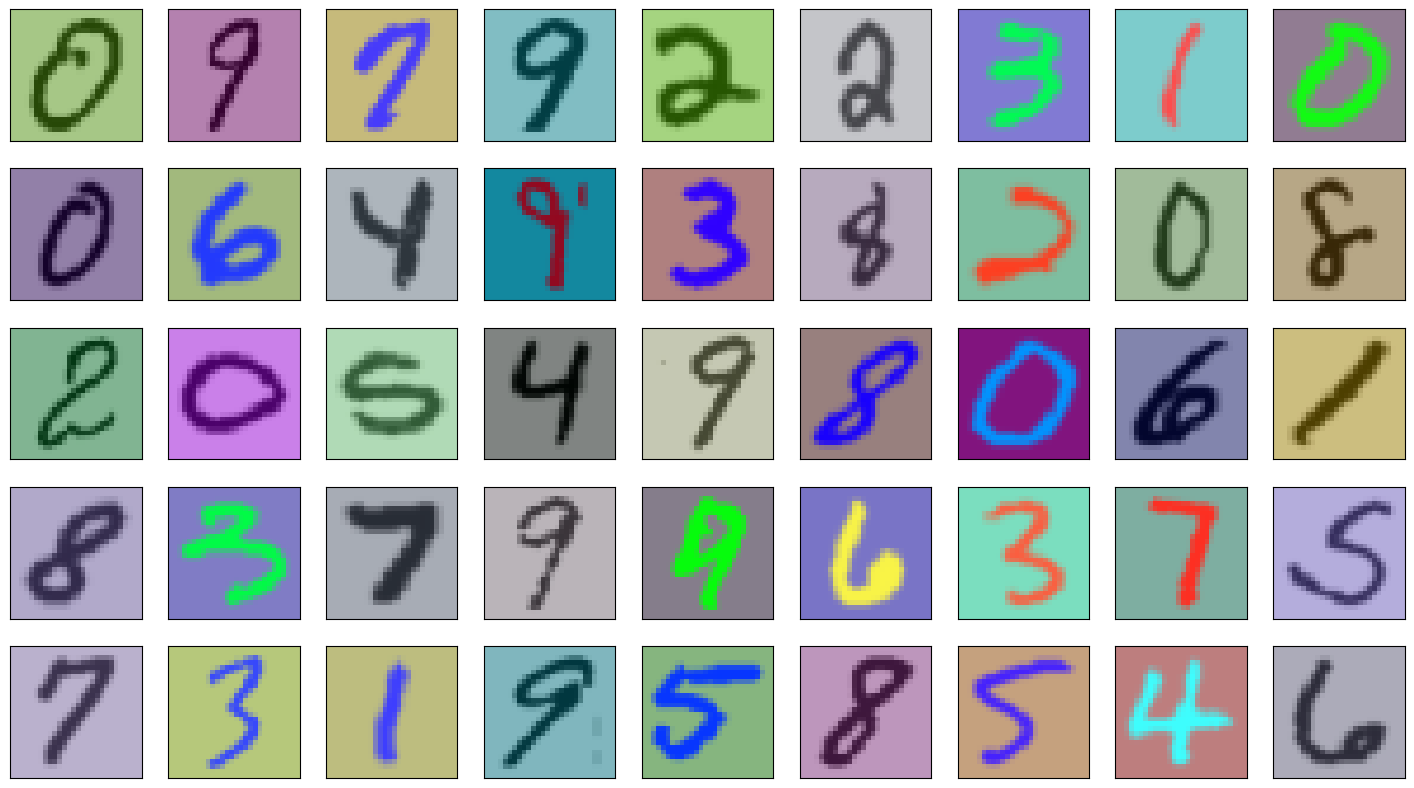

In [19]:
plot_images_28(colorized_test[40000:], n_rows=5)

In [20]:
import h5py
#print(colorized_train.shape)
print(colorized_train.shape)
print(colorized_test.shape)

with h5py.File('../FFF/data/cc_mnist_big/data.h5', 'w') as f:
    f.create_dataset('train_images', data=colorized_train, compression='gzip')
    f.create_dataset('test_images', data=colorized_test, compression='gzip')

torch.Size([1200000, 3, 28, 28])
torch.Size([200000, 3, 28, 28])


In [21]:
f.close()

In [45]:
print(colorized_train.shape)

torch.Size([240000, 3, 28, 28])


In [4]:
#checkpoint = lightning_trainable.utils.find_checkpoint(root="data/cc_mnist/subject_model28vae", version=1, epoch=274)
VAE_dc = fff.SomeModel.load_from_checkpoint("data/cc_mnist/subject_model/checkpoints/best.ckpt")

torch.Size([240000, 28, 28])
cond_dim:  0
output_dim:  96


In [6]:
#checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/Cnn_vae", version=2, epoch="last")
VAE = fff.FiberModel.load_from_checkpoint("lightning_logs/C_vae_54/version_3/checkpoints/last.ckpt")

(240000, 3, 28, 28)
cond_dim:  0
output_dim:  108


In [7]:
torch.set_grad_enabled(False)

/tmp/ipykernel_1447194/3243386645.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)


tensor(0.0020)


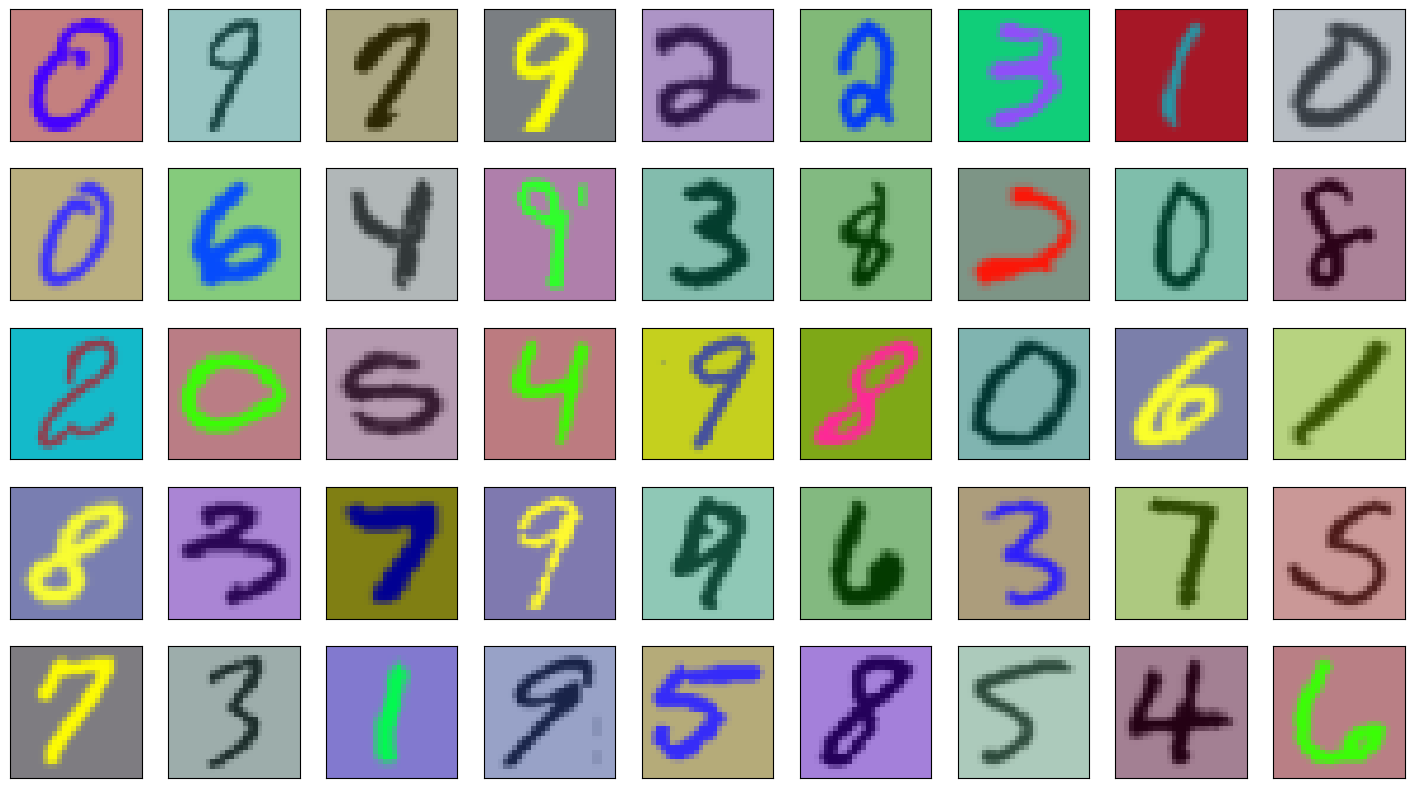

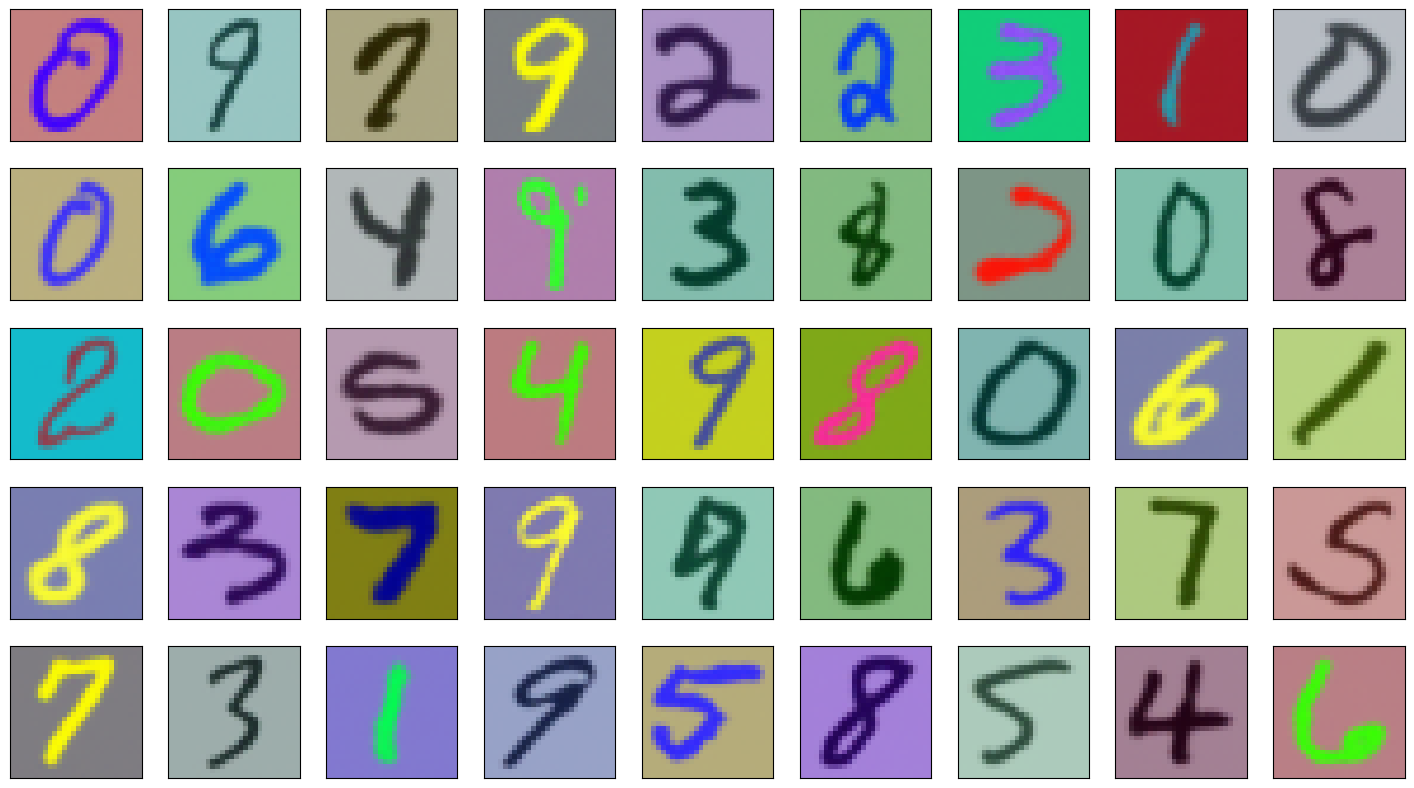

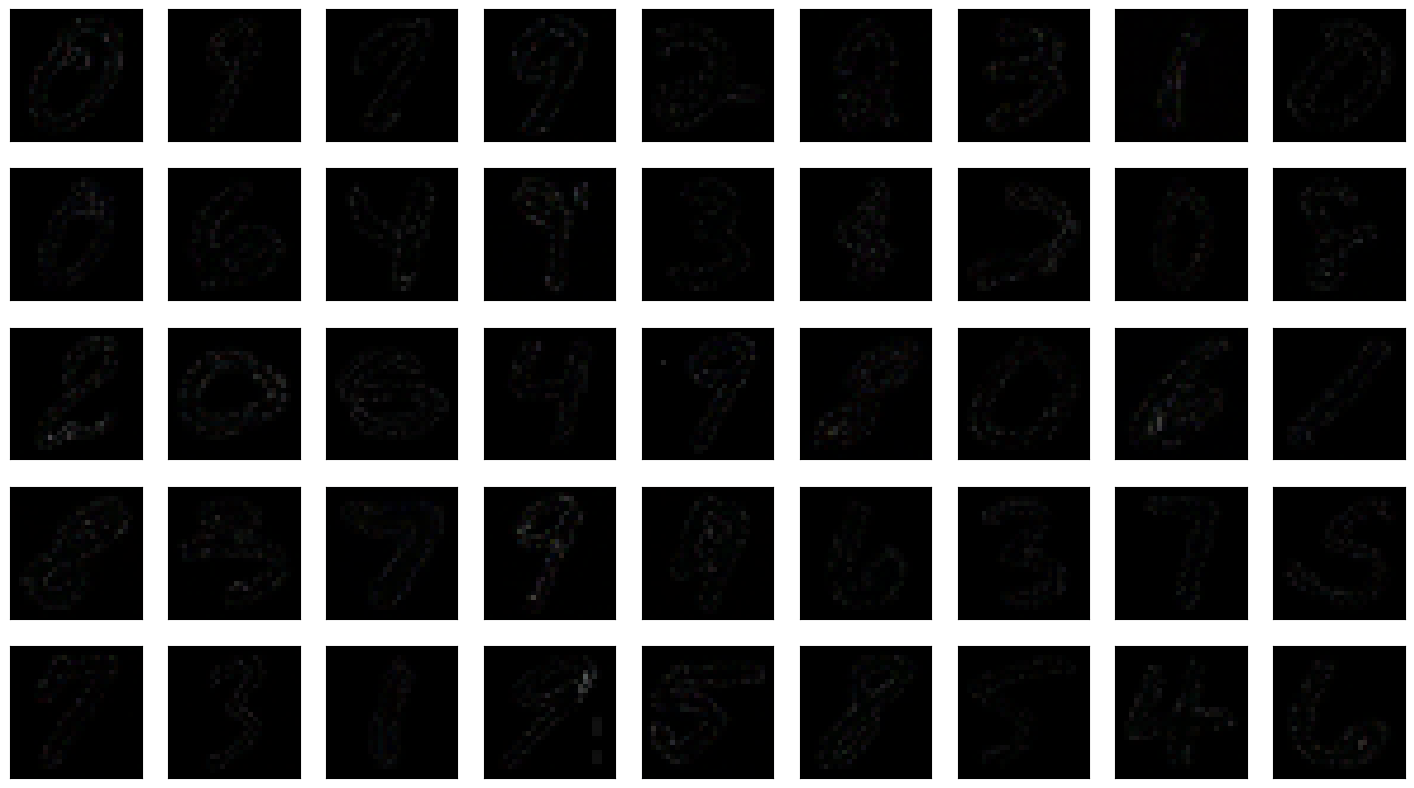

In [10]:
colorized_test = Xt
true_train_batch = colorized_test
train_conditioned = VAE.apply_conditions((true_train_batch,))
true_train_c = train_conditioned.condition
true_train_samples = train_conditioned.x0
batch_size = VAE.hparams.batch_size
device = VAE.device

true_train_z = torch.cat([
    VAE.encode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_samples.split(batch_size), true_train_c.split(batch_size))
])
true_train_rec = torch.cat([
    VAE.decode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_z.split(batch_size), true_train_c.split(batch_size))
])
plot_images_28(torch.abs(true_train_batch.reshape(-1,3,28,28)), n_rows=5)
plot_images_28(torch.abs(true_train_rec.reshape(-1,3,28,28)), n_rows=5)
plot_images_28(torch.abs((true_train_rec.reshape(-1,3,28,28)-true_train_batch).reshape(-1,3,28,28)), n_rows=5)
print(torch.min(true_train_rec.reshape(-1,3,28,28)))

/tmp/ipykernel_3449475/3243386645.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)


tensor(0.0054)


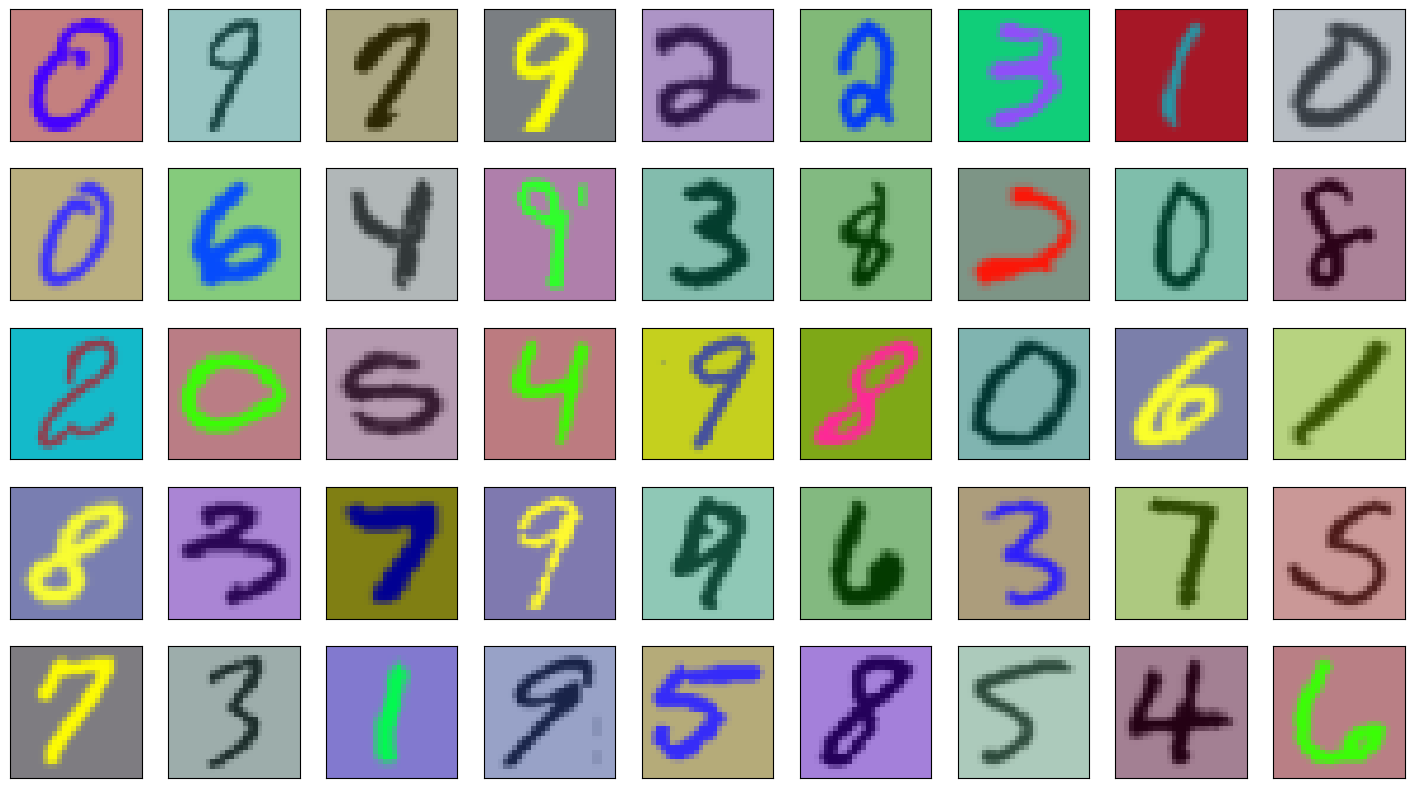

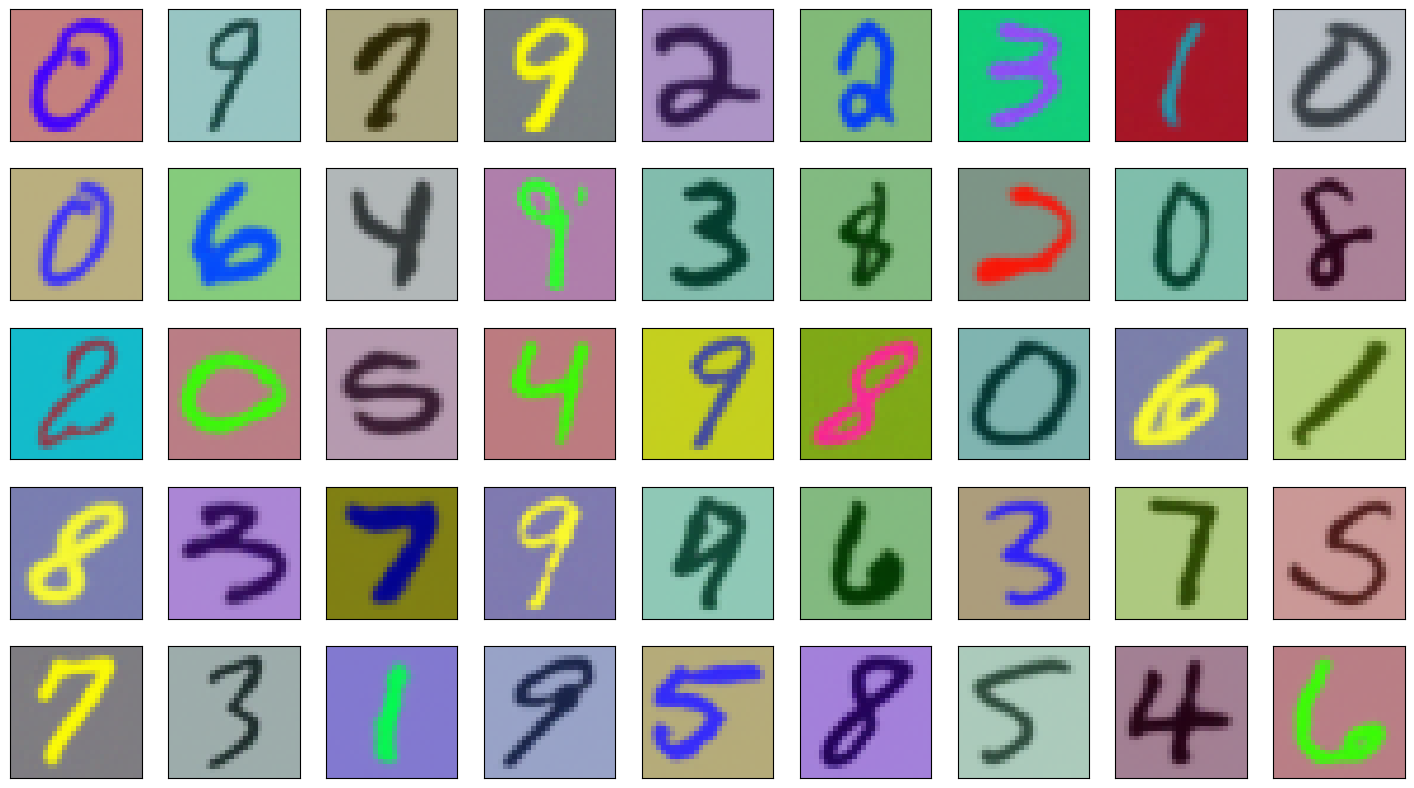

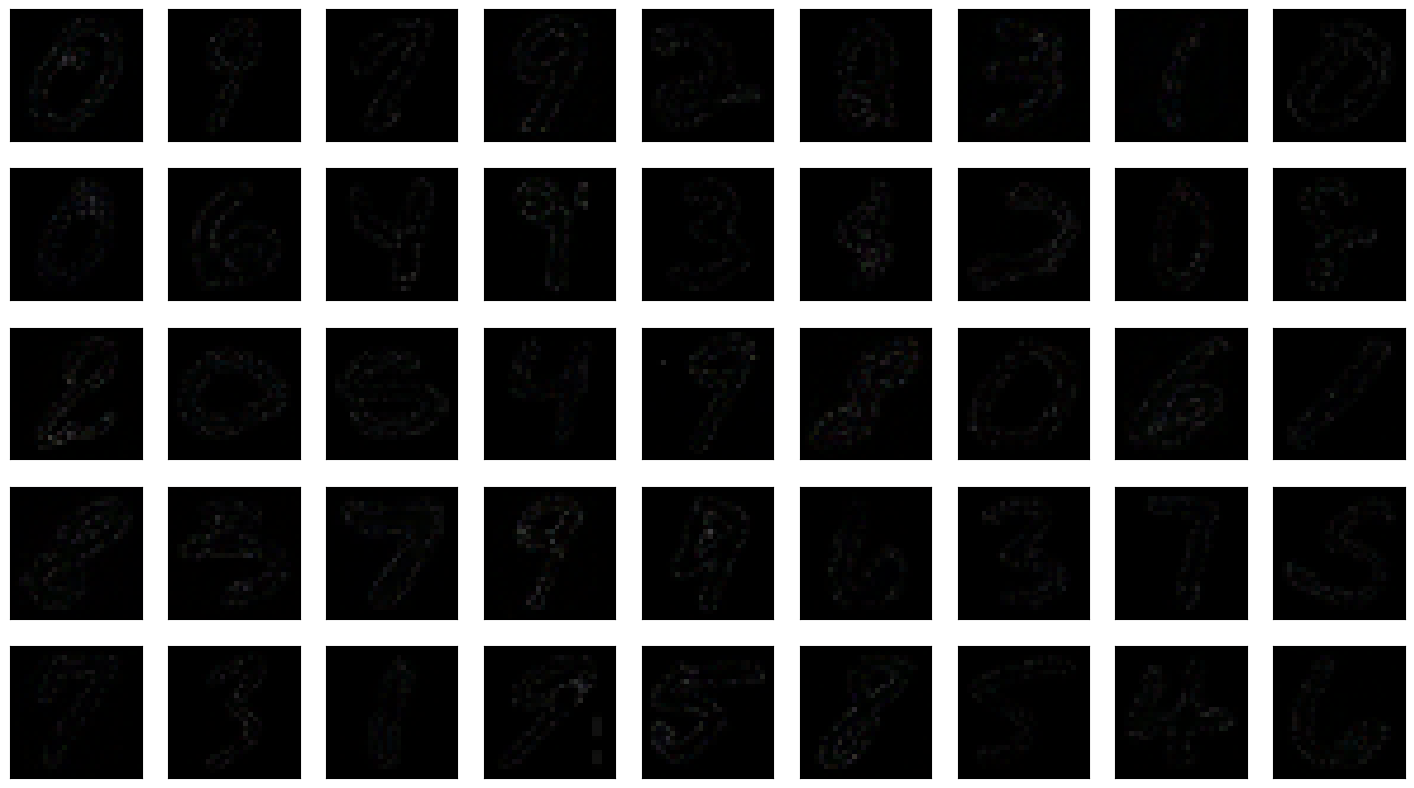

In [8]:
colorized_test = Xt
true_train_batch = colorized_test
train_conditioned = VAE.apply_conditions((true_train_batch,))
true_train_c = train_conditioned.condition
true_train_samples = train_conditioned.x0
batch_size = VAE.hparams.batch_size
device = VAE.device

true_train_z = torch.cat([
    VAE.encode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_samples.split(batch_size), true_train_c.split(batch_size))
])
true_train_rec = torch.cat([
    VAE.decode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_z.split(batch_size), true_train_c.split(batch_size))
])
plot_images_28(torch.abs(true_train_batch.reshape(-1,3,28,28)), n_rows=5)
plot_images_28(torch.abs(true_train_rec.reshape(-1,3,28,28)), n_rows=5)
plot_images_28(torch.abs((true_train_rec.reshape(-1,3,28,28)-true_train_batch).reshape(-1,3,28,28)), n_rows=5)
print(torch.min(true_train_rec.reshape(-1,3,28,28)))

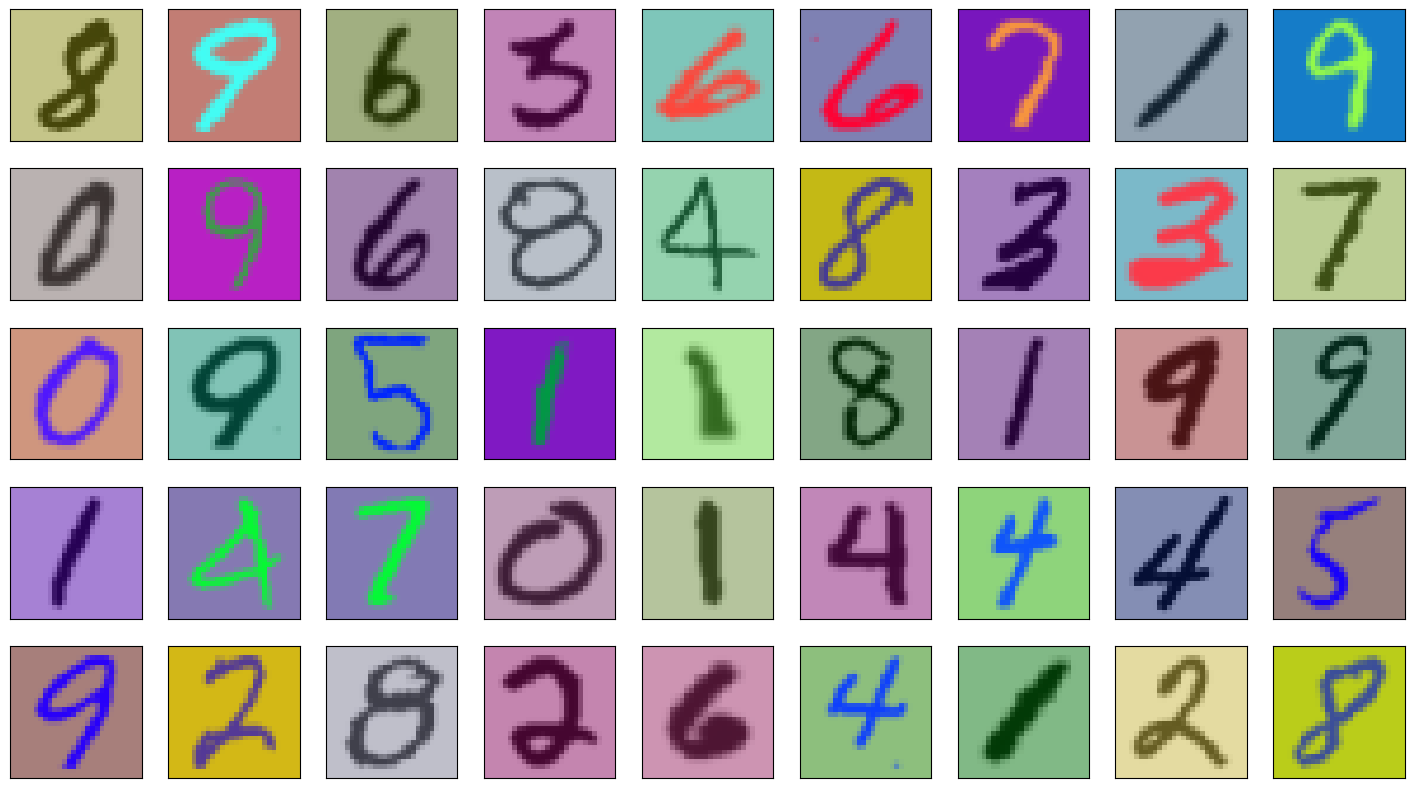

In [18]:
plot_images_28(torch.abs(Xtr.reshape(-1,3,28,28)), n_rows=5)

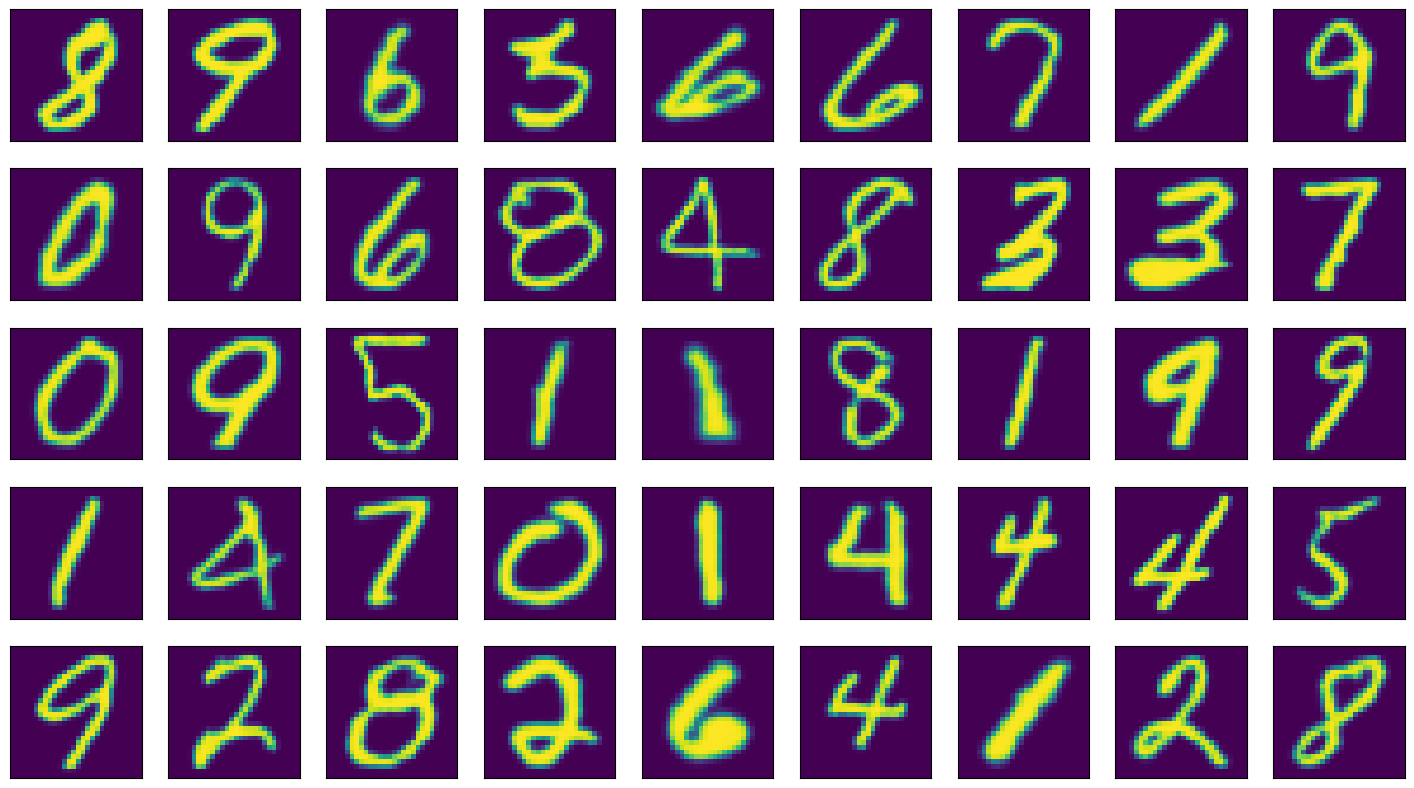

In [23]:
train_conditioned = VAE_dc.apply_conditions((ztr,))
true_train_c = train_conditioned.condition
Xtr_rec = torch.cat([
    VAE_dc.decode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(ztr.split(batch_size), true_train_c.split(batch_size))
])
plot_images_28(Xtr_rec.reshape(-1,1,28,28), n_rows=5)

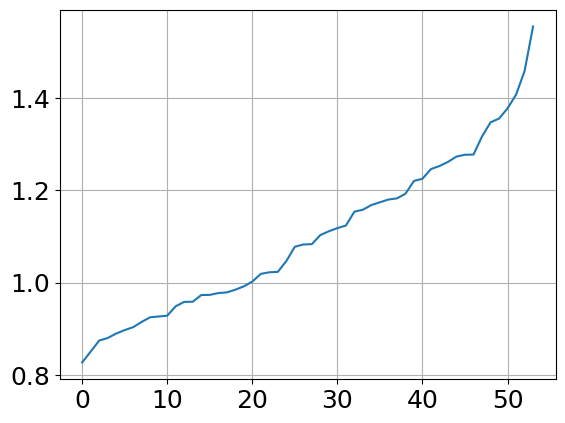

In [20]:
variance = torch.sort(torch.var(true_train_z,0)).values
plt.plot(np.arange(54),variance.detach().cpu().numpy())
plt.grid()

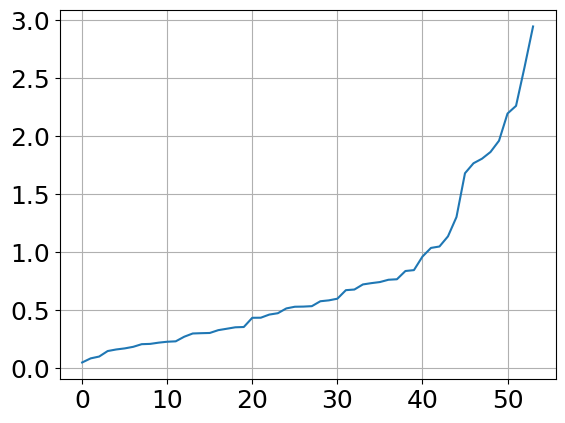

In [16]:
variance = torch.sort(torch.var(true_train_z,0)).values
plt.plot(np.arange(54),variance.detach().cpu().numpy())
plt.grid()

In [15]:
def detect_colors(x_data):
    background_colors = torch.mean(x_data[:,:,:,0],-1)
    return background_colors
def compute_angles(colors):
    theta = torch.acos(colors[:,2])
    phi = torch.acos(colors[:,0] / torch.sqrt(colors[:,0]**2 + colors[:,1]**2))
    return theta, phi
def rotate_and_project(x, theta, phi):
    x = x.reshape(-1,3,28*28)
    print(theta.shape)
    sin_th = torch.sin(theta).unsqueeze(-1).expand(-1,28*28)
    x_b = sin_th * torch.cos(phi).unsqueeze(-1).expand(-1,28*28) * x[:,0,:] + sin_th * torch.sin(phi.unsqueeze(-1).expand(-1,28*28)) * x[:,1,:] + torch.cos(theta).unsqueeze(-1).expand(-1,28*28) * x[:,2,:]
    return x_b

In [16]:
"""
def decolorize(x_colored, b_colors):
    theta, phi = compute_angles(b_colors)
    plt.hist(theta, bins=60, density=True)
    plt.show()
    x_rot = rotate_and_project(x_colored, theta, phi)
    x_dc = -3 * x_rot + 1
    return x_dc
"""
def decolorize(x_c, c):
    # x_c = (1-x) c + x * ((c+0.5)%1)
    #--> x = (x_c-c)/((c+0.5)%1 - c)
    c = c.unsqueeze(-1).expand(-1,3,28*28).reshape(-1,3,28,28)
    x_dc = (x_c-c) / (((c+0.5)%1) - c)
    print(x_dc.shape)
    #return torch.abs(x_dc[:,1,:,:])
    return torch.mean(torch.abs(x_dc),1)

torch.Size([200000, 3, 28, 28])


RuntimeError: The size of tensor a (200000) must match the size of tensor b (40000) at non-singleton dimension 0

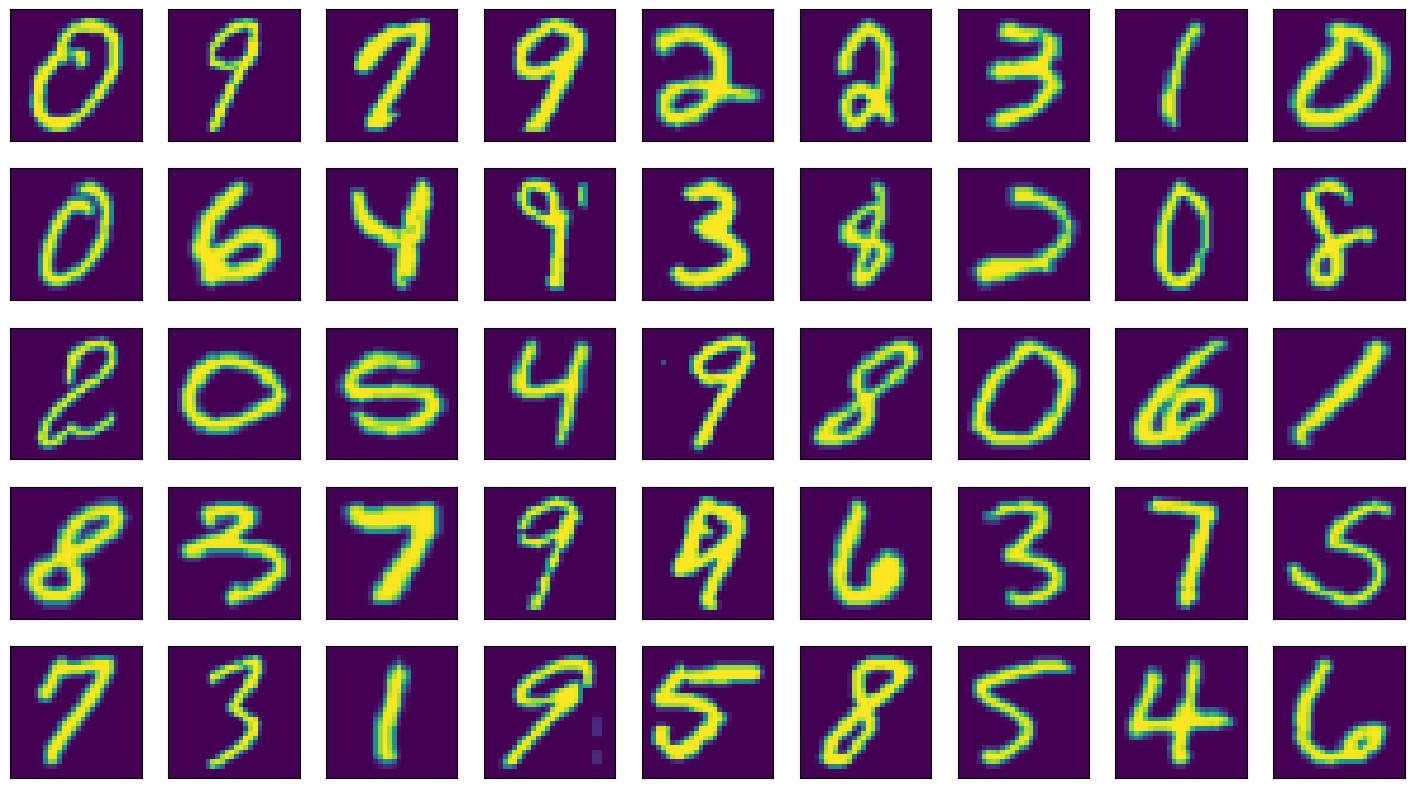

In [17]:
x_c = colorized_test.reshape(-1,3,28,28)
bg_colors = detect_colors(x_c)
decolorized_train = decolorize(x_c, bg_colors)
plot_images_28(decolorized_train, n_rows=5)
plot_images_28(torch.abs(decolorized_train-x_test/255.), n_rows=2)
plot_images_28(x_test/255., n_rows=2)

torch.Size([40000, 3, 28, 28])


/tmp/ipykernel_2128810/3243386645.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  axes[i][j].imshow(data[i*n_columns +j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)


tensor(1.0000)
tensor(0.)


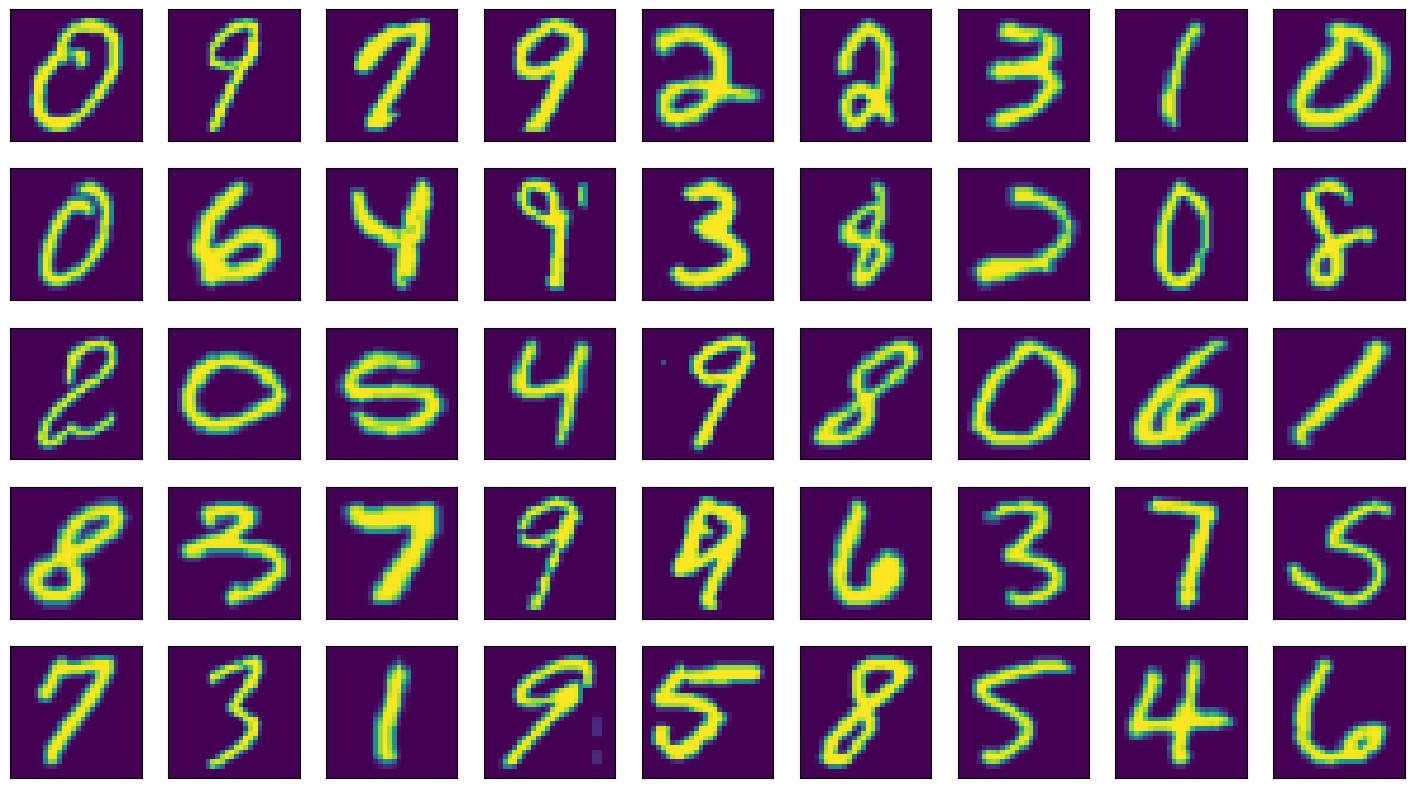

In [10]:
colorized_test = Xt.reshape(-1,3,28,28)
bg_colors = detect_colors(colorized_test)
decolorized_test = decolorize(colorized_test, bg_colors)
plot_images_28(decolorized_test, n_rows=5)
print(torch.max(decolorized_test))

print(torch.min(decolorized_test))

torch.Size([240000, 3, 28, 28])
tensor(1.0000)
tensor(0.)


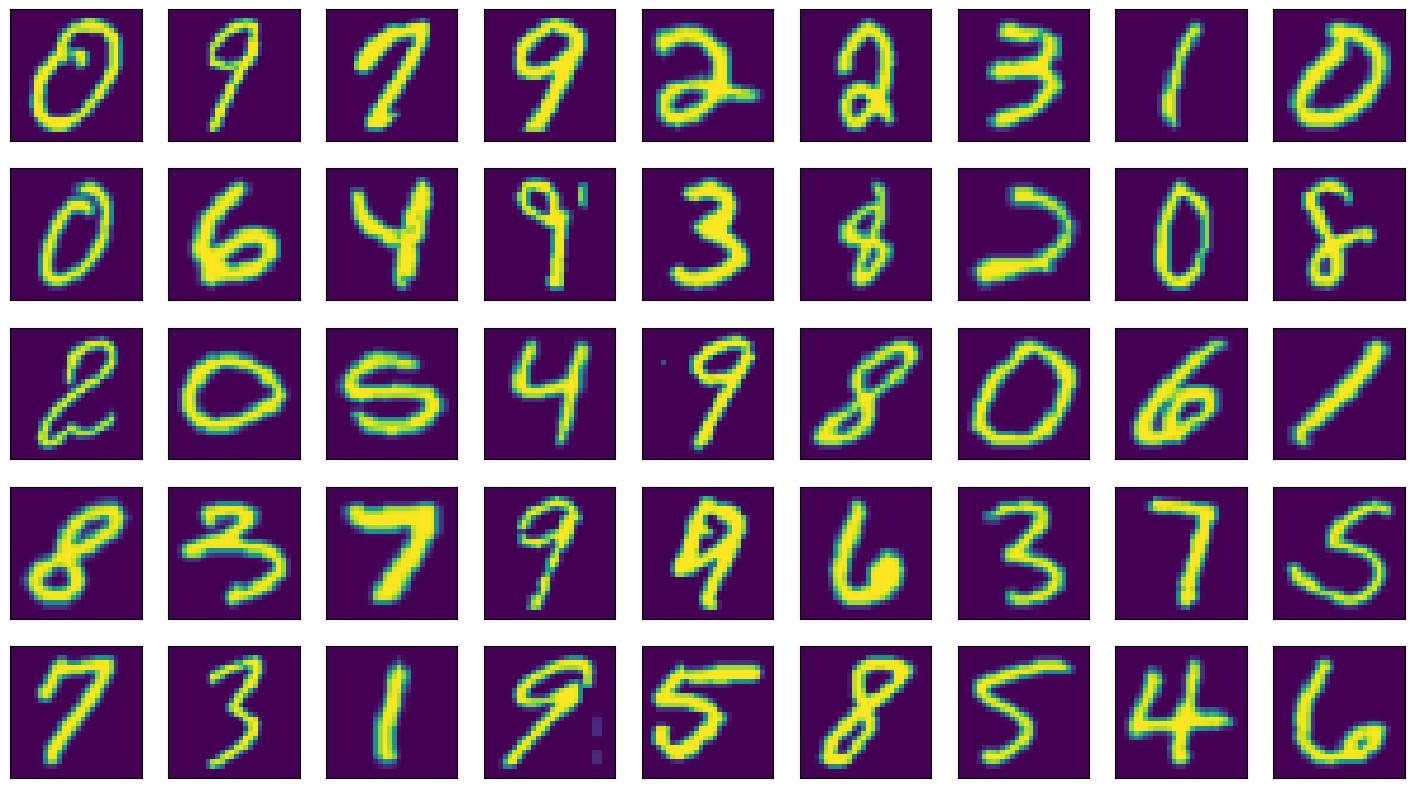

In [11]:
colorized_test = Xtr.reshape(-1,3,28,28)
bg_colors = detect_colors(colorized_test)
decolorized_train = decolorize(colorized_test, bg_colors)
plot_images_28(decolorized_test, n_rows=5)
print(torch.max(decolorized_test))

print(torch.min(decolorized_test))

tensor(4.7981e-09)


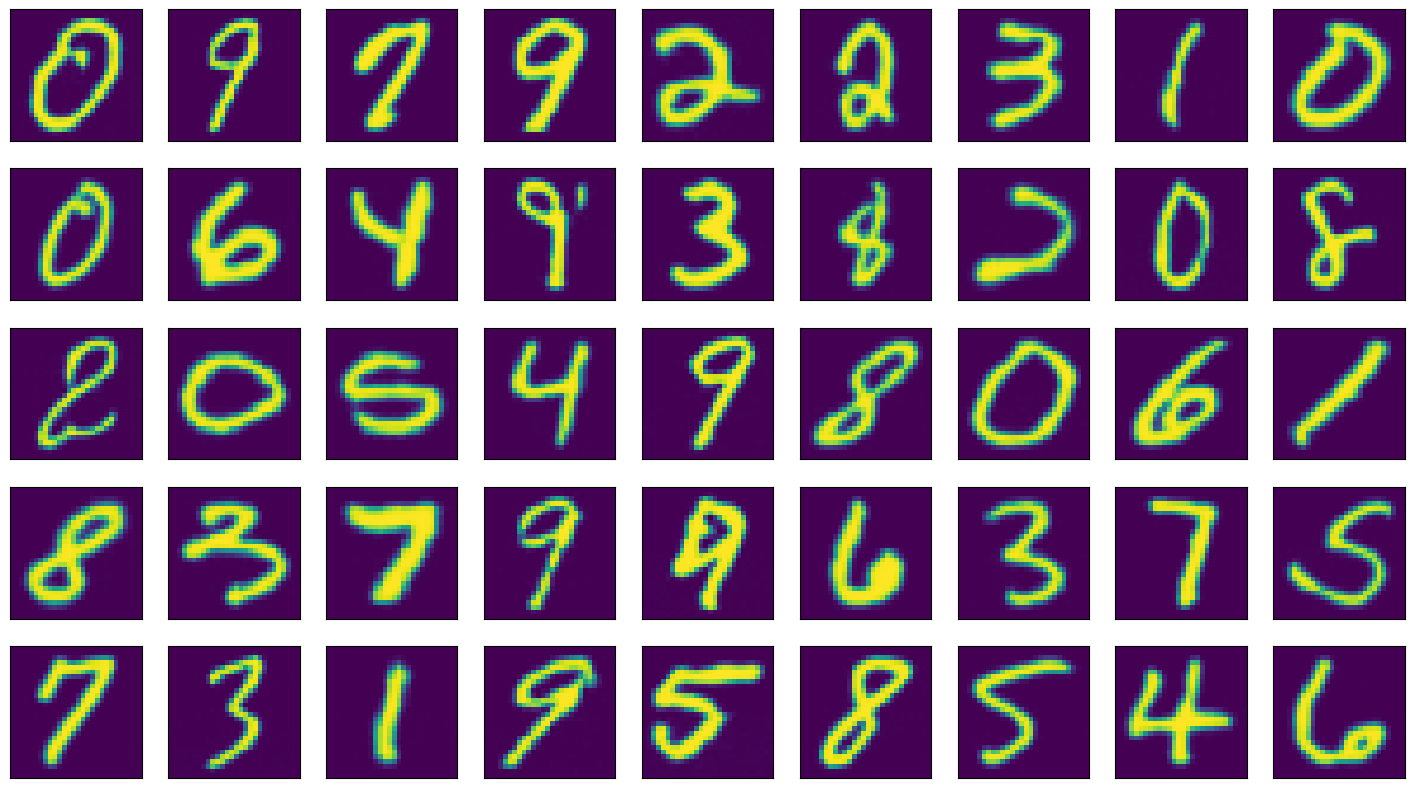

In [77]:
bg_colors, fg_colors = detect_colors(true_train_rec.reshape(-1,3,28,28))
decolorized_rec = decolorize(true_train_rec.reshape(-1,3,28,28), bg_colors, fg_colors)
plot_images_28(decolorized_rec, n_rows=5)
print(torch.mean(decolorized_test-(x_test/255.)))

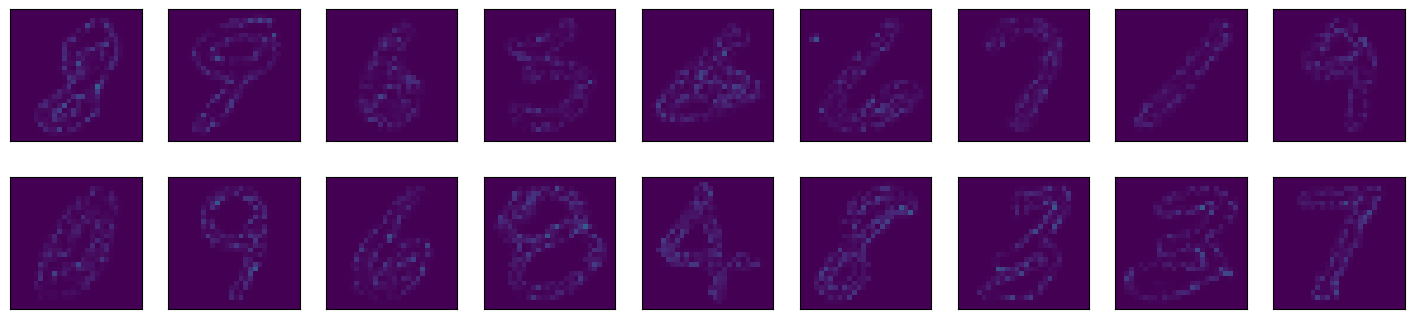

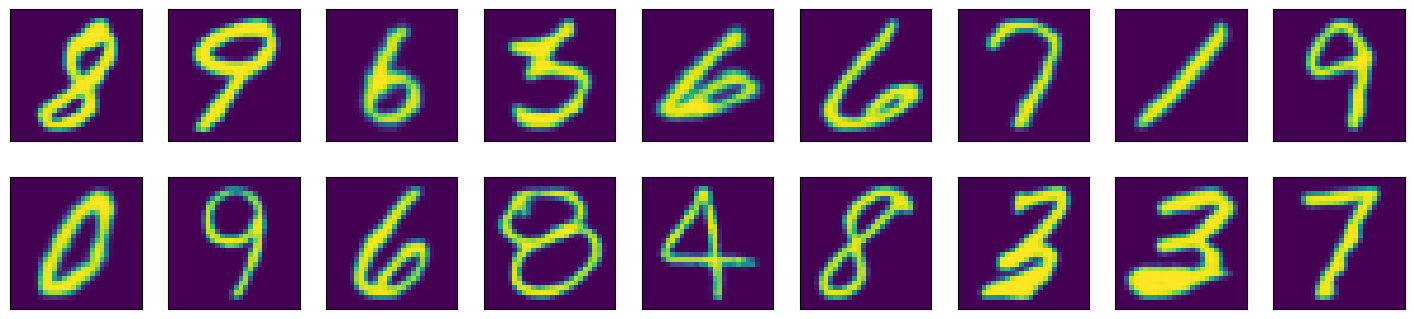

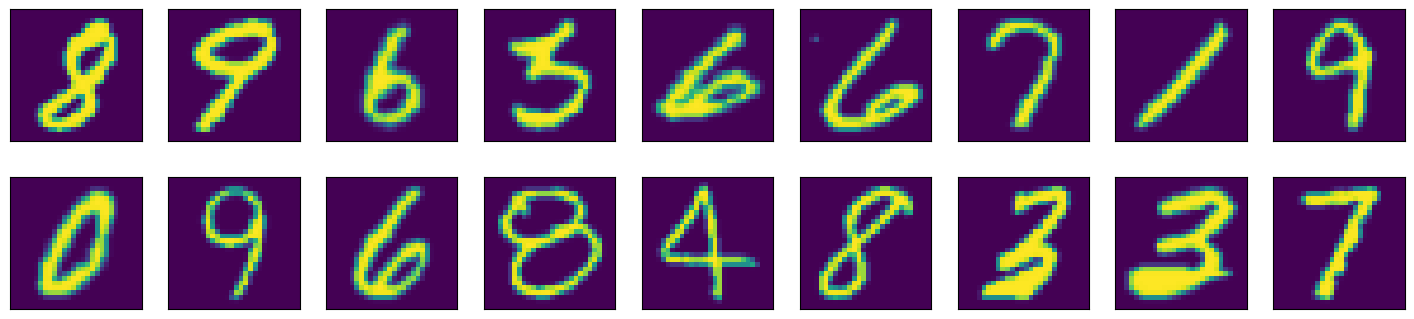

In [12]:
true_train_batch = decolorized_train
train_conditioned = VAE_dc.apply_conditions((true_train_batch,))
true_train_c = train_conditioned.condition
true_train_samples = train_conditioned.x0
batch_size = VAE_dc.hparams.batch_size
device = VAE_dc.device

rec_train_z = torch.cat([
    VAE_dc.encode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_samples.split(batch_size), true_train_c.split(batch_size))
])
true_train_rec = torch.cat([
    VAE_dc.decode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(rec_train_z.split(batch_size), true_train_c.split(batch_size))
])
plot_images_28(torch.abs(decolorized_train[:100].reshape(-1,1,28,28)-true_train_rec[:100].reshape(-1,1,28,28)),n_rows=2)
plot_images_28(true_train_rec[:100].reshape(-1,1,28,28),n_rows=2)
plot_images_28(decolorized_train[:100].reshape(-1,1,28,28),n_rows=2)

RuntimeError: The size of tensor a (240000) must match the size of tensor b (40000) at non-singleton dimension 0

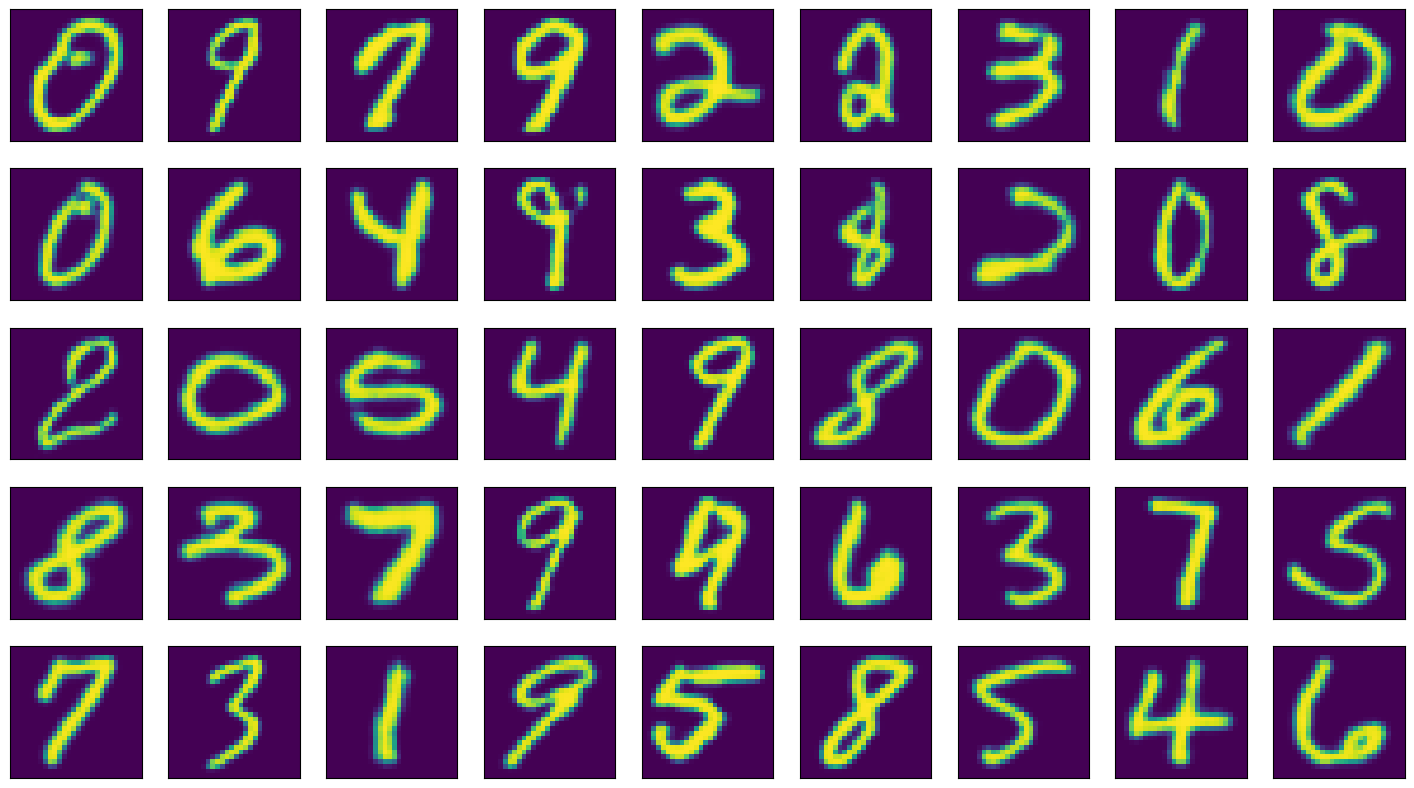

In [14]:
true_train_batch = decolorized_test
train_conditioned = VAE_dc.apply_conditions((true_train_batch,))
true_train_c = train_conditioned.condition
true_train_samples = train_conditioned.x0
batch_size = VAE_dc.hparams.batch_size
device = VAE_dc.device

rec_test_z = torch.cat([
    VAE_dc.encode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(true_train_samples.split(batch_size), true_train_c.split(batch_size))
])
true_train_recrec = torch.cat([
    VAE_dc.decode(batch.to(device), c_batch.to(device)).cpu()
    for batch, c_batch in zip(rec_test_z.split(batch_size), true_train_c.split(batch_size))
])
plot_images_28(true_train_recrec.reshape(-1,1,28,28),n_rows=5)
plot_images_28((true_train_rec-true_train_recrec).abs().reshape(-1,1,28,28),n_rows=5)
print((true_train_rec-true_train_recrec).abs().mean())

In [114]:
dist = torch.abs(rec_train_z[1:]-recrec_train_z[1:])
print(dist[0])
print(dist.mean())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)


IndexError: index 48 is out of bounds for dimension 1 with size 48

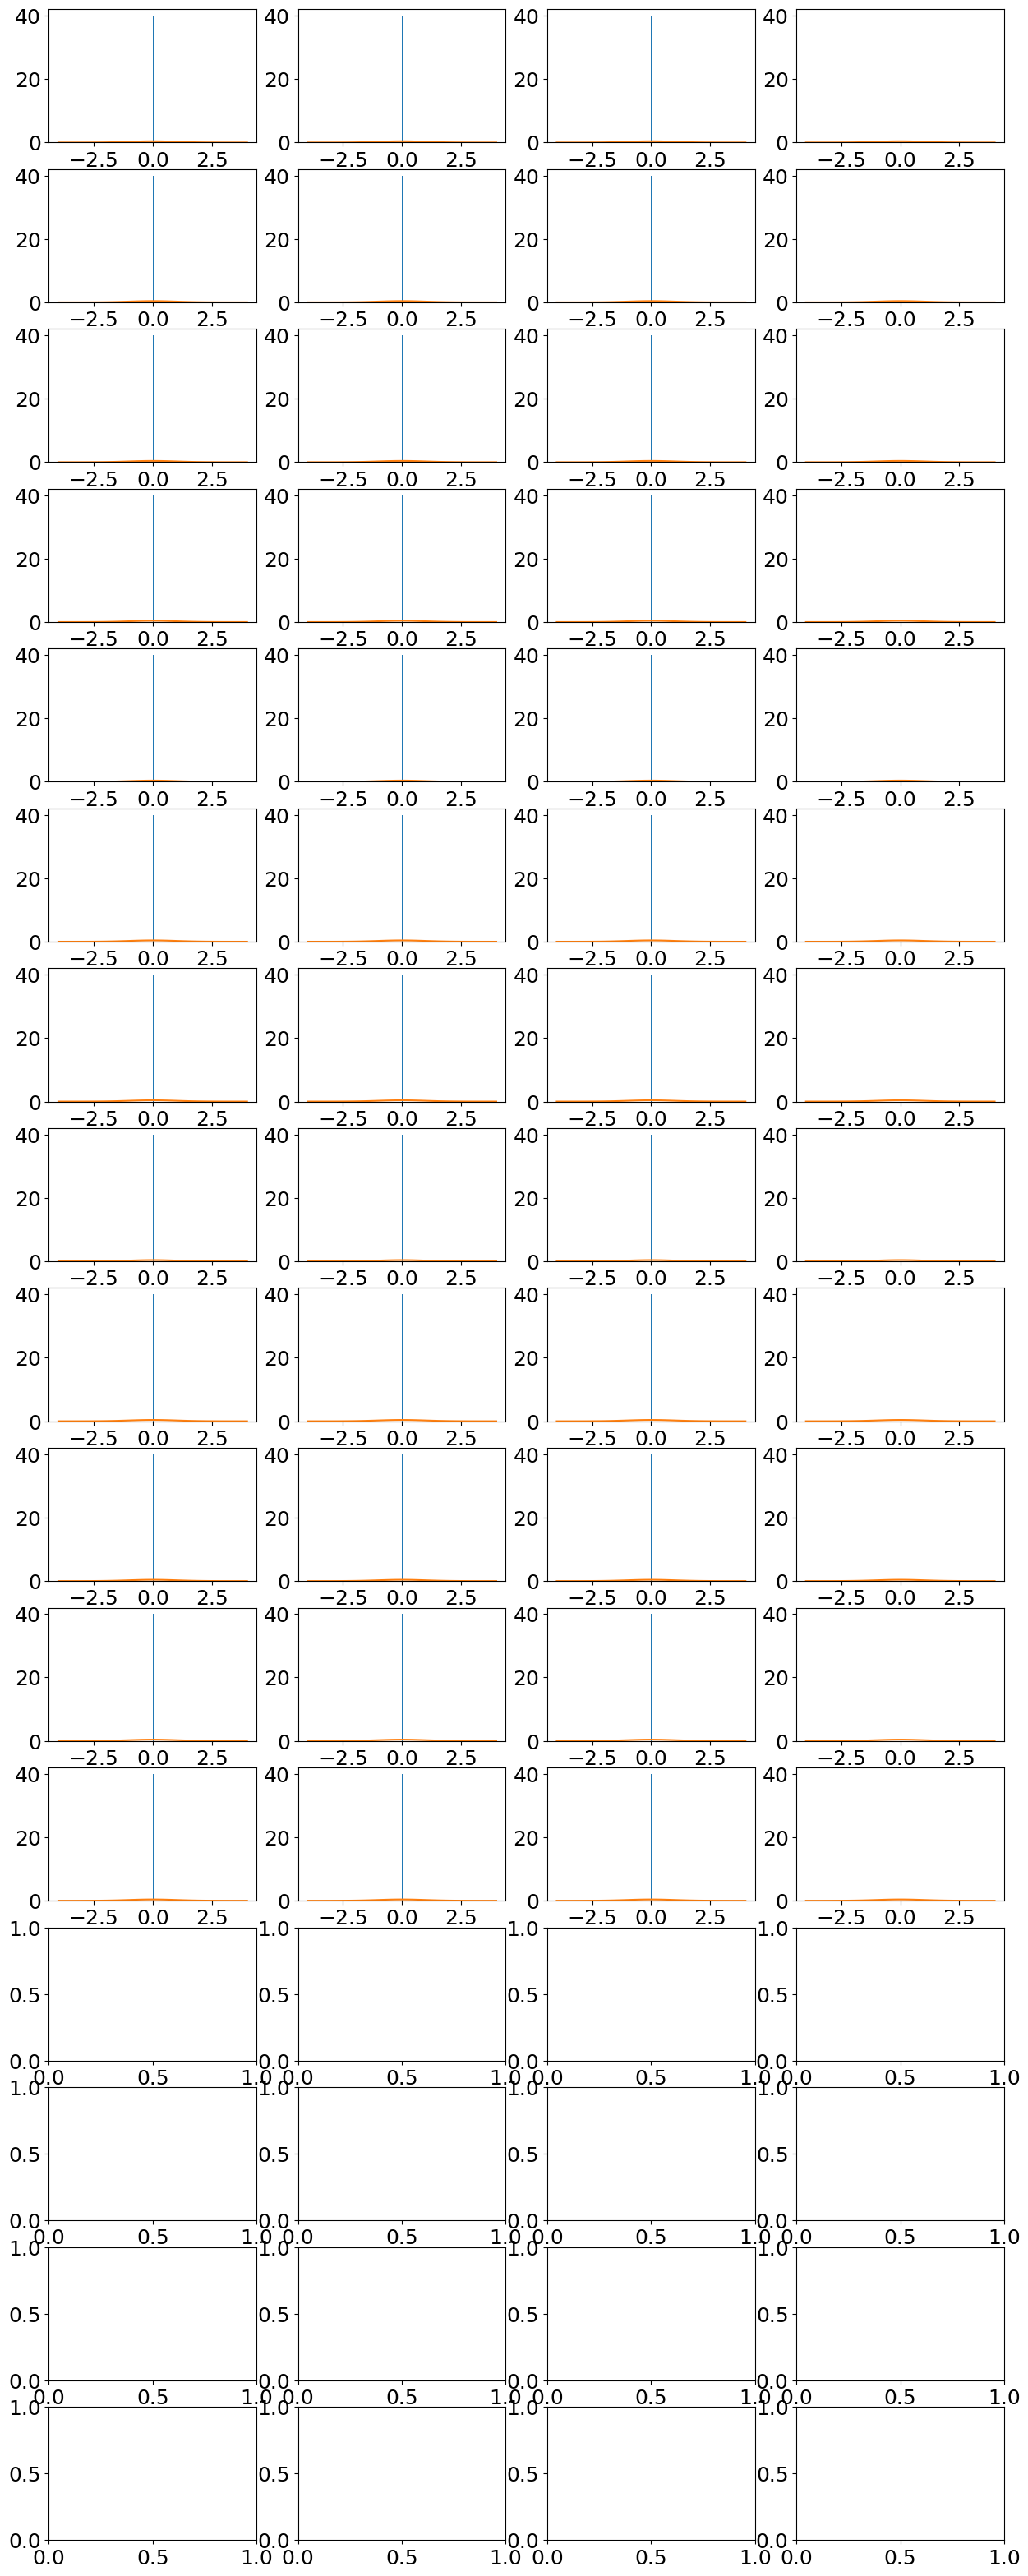

In [115]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)
nrows = 16
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(15, nrows*2.5))
a = np.linspace(-4,4,100)
for i in range(nrows):
    for j in range(4):
        axes[i][j].hist([:,i*4+j], bins=40, label="Samples", density=True)
        axes[i][j].plot(a, normal(a))

In [20]:
#check background
bg_theta_true = bcolor_1*torch.pi/2
bg_phi_true = bcolor_2*torch.pi/2
bg_colors_det =  bg_colors
print(bg_colors_det.shape)
print(torch.sum(bg_colors_det**2,-1)[:10])
bg_theta_det = torch.acos(bg_colors_det[:,2])
bg_phi_det = torch.acos(bg_colors_det[:,0] / torch.sin(bg_theta_det))
check_bg_theta = torch.mean(torch.sqrt((bg_theta_true - bg_theta_det)**2))
check_bg_phi = torch.mean(torch.sqrt((bg_phi_true - bg_phi_det)**2))
print(check_bg_theta)
#print(bg_phi_det[:30])
#print(bg_phi_true[:30])
print(check_bg_phi)

torch.Size([40000, 3])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
tensor(1.2687e-08)
tensor(2.8897e-08)


In [22]:
#check foreground
fg_theta_true = dcolor_1*torch.pi/2
fg_phi_true = dcolor_2*torch.pi/2
fg_colors_det =  fg_colors
print(fg_colors_det.shape)
print(torch.sum(fg_colors_det**2,-1)[:10])
fg_theta_det = torch.acos(fg_colors_det[:,2])
fg_phi_det = torch.acos(fg_colors_det[:,0] / torch.sqrt(fg_colors_det[:,0]**2 + fg_colors_det[:,1]**2))
check_fg_theta = torch.mean(torch.sqrt((fg_theta_true - fg_theta_det)**2))
check_fg_phi = torch.mean(torch.sqrt((fg_phi_true - fg_phi_det)**2))
print(check_fg_theta)
print(fg_phi_true[:30])
print(check_fg_phi)

torch.Size([40000, 3])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
tensor(7.3236e-07)
tensor([0.1034, 0.1736, 0.1034, 1.5251, 0.0024, 0.8688, 0.8731, 0.8677, 0.0575,
        0.8193, 0.8998, 0.8240, 0.8496, 0.0427, 0.0143, 0.0949, 0.8607, 0.8456,
        0.0146, 0.8347, 0.1237, 0.8874, 0.8973, 0.0093, 0.0315, 0.1002, 0.0277,
        0.0232, 0.0138, 0.8726])
tensor(nan)


In [15]:
import h5py
#print(colorized_train.shape)
print(Xtr.shape)
print(Xt.shape)
print(rec_train_z.shape)
print(rec_test_z.shape)

with h5py.File('../FFF/data/cc_mnist/data.h5', 'w') as f:
    f.create_dataset('train_images', data=Xtr, compression='gzip')
    f.create_dataset('train_z', data=rec_train_z)
    f.create_dataset('test_images', data=Xt, compression='gzip')
    f.create_dataset('test_z', data=rec_test_z)



torch.Size([240000, 3, 28, 28])
torch.Size([40000, 3, 28, 28])
torch.Size([240000, 48])
torch.Size([40000, 48])


In [124]:
shutil.copytree("lightning_logs/28vae/version_1", f"data/cc_mnist/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

'data/cc_mnist/subject_model'

In [6]:
# To load it back:
with h5py.File('/export/data/wjoran/FFF/data/cc_mnist/data.h5', 'r') as f:
    Xtr = torch.from_numpy(f['train_images'][:])
    ztr = torch.from_numpy(f['train_z'][:])
    Xt = torch.from_numpy(f['test_images'][:])
    zt = torch.from_numpy(f['test_z'][:])

In [11]:
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/28VAE", version=8, epoch="last")
VAE = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint)

torch.Size([240000, 1, 28, 28])
cond_dim:  0
latent_dim:  64


In [ ]:
def eval_vae(model2plt):
    device = model2plt.device
    
    data = {}
    true_test_batch = model2plt.test_data[:]
    test_conditioned = model2plt.apply_conditions(true_test_batch)
    true_test_c = test_conditioned.condition
    true_test_samples = test_conditioned.x0
    
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    true_test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_test_samples.split(batch_size), true_test_c.split(batch_size))
    ])
    print(true_test_z.shape)
    
    print("reconstructing...")
    true_reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(true_test_z.split(batch_size), true_test_c.split(batch_size))
    ])

    print("sampling...")
    z_sampled = torch.randn_like(true_test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), true_test_c.split(batch_size))
    ])
    print(true_reconstruction[0,:10])
    
    #plotting...
    plot_images_28(true_test_samples, "Original", "vae")
    plot_images_28(true_reconstruction, "Reconstruction", "vae")
    plot_images_28(x_sampled, "Sampled", "vae")

In [157]:
class DownsampleTransform:
        def __init__(self, target_shape, algorithm=Image.Resampling.LANCZOS):
            self.width, self.height = target_shape
            self.algorithm = algorithm

        def __call__(self, img):
            img = img.resize((self.width+2, self.height+2), self.algorithm)
            img = img.crop((1, 1, self.width+1, self.height+1))
            return img

# concatenate a few transforms
transform = Compose([
    ToTensor(),
])

train_dataset = EMNIST(root="data", train=True, split="digits", transform=transform)
test_dataset = EMNIST(root="data", train=False, split="digits", transform=transform)

In [167]:
print(train_dataset.data.shape)
print(val_data.shape)
print(test_data.shape)

torch.Size([240000, 28, 28])
torch.Size([10000, 256])
torch.Size([40000, 256])


In [169]:
from torchvision.transforms import functional as F
from PIL import Image

g_scale = Grayscale(num_output_channels=1)
def rotate_image(image, angle):
    """Rotate a PIL Image by the given angle."""
    to_tens = ToTensor()
    image = F.rotate(image.unsqueeze(0), angle.item())
    to_pil = ToPILImage()
    image = to_pil(image)
    image = image.resize((16+2, 16+2), Image.Resampling.LANCZOS)
    image = image.crop((1, 1, 16+1, 16+1))
    image = g_scale(image)
    image = to_tens(image)
    return image

# Apply the rotations
rotated_train_data = torch.cat([rotate_image(img, angle) for img, angle in zip(train_dataset.data, sample_Gaussian_mixture(240000))])
rotated_test_data = torch.cat([rotate_image(img, angle) for img, angle in zip(test_dataset.data, sample_Gaussian_mixture(40000))])

In [173]:
from math import prod
train_data = rotated_train_data
test_data = rotated_test_data
val_data_split = 10000
val_data = train_data[-val_data_split:]
train_data = train_data[:-val_data_split]

# To PyTorch tensors
if not torch.is_tensor(train_data):
    train_data = torch.from_numpy(train_data)
    val_data = torch.from_numpy(val_data)
    test_data = torch.from_numpy(test_data)

# Permute to (N, C, H, W)
if train_data.shape[-1] in [1, 2, 3]:
    train_data = train_data.permute(0, 3, 1, 2)
    val_data = val_data.permute(0, 3, 1, 2)
    test_data = test_data.permute(0, 3, 1, 2)

# Reshape to (N, D)
data_size = prod(train_data.shape[1:])
if train_data.shape != (train_data.shape[0], data_size):
    train_data = train_data.reshape(-1, data_size)
    val_data = val_data.reshape(-1, data_size)
    test_data = test_data.reshape(-1, data_size)

# Normalize to [0, 1]
if train_data.max() > 1:
    train_data = train_data / 255.
    val_data = val_data / 255.
    test_data = test_data / 255.


train_targets = train_dataset.targets
val_targets = train_targets[-val_data_split:]
train_targets = train_targets[:-val_data_split]
test_targets = test_dataset.targets

if not torch.is_tensor(train_targets):
    train_targets = torch.tensor(train_targets)
    val_targets = torch.tensor(val_targets)
    test_targets = torch.tensor(test_targets)

print("save data...")
data = {}

data["train_x"] = train_data.cpu().numpy()
data["train_y"] = train_targets.cpu().numpy()

data["val_x"] = val_data.cpu().numpy()
data["val_y"] = val_targets.cpu().numpy()

data["test_x"] = test_data.cpu().numpy()
data["test_y"] = test_targets.cpu().numpy()

Path(f"data/mnist_rot").mkdir(parents=True, exist_ok=True)
fileName = f"data/mnist_rot/data"
fileObject = open(fileName, 'wb')

pkl.dump(data, fileObject)

save data...


In [164]:
print(rotated_val_data.squeeze().shape)

torch.Size([20, 16, 16])


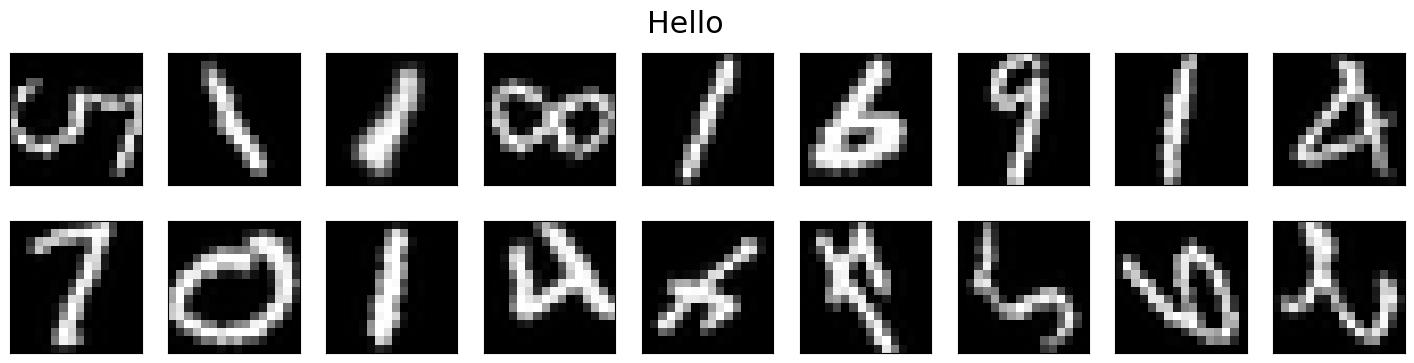

In [183]:
plot_images_16(rotated_train_data[20:].squeeze(), "Hello")

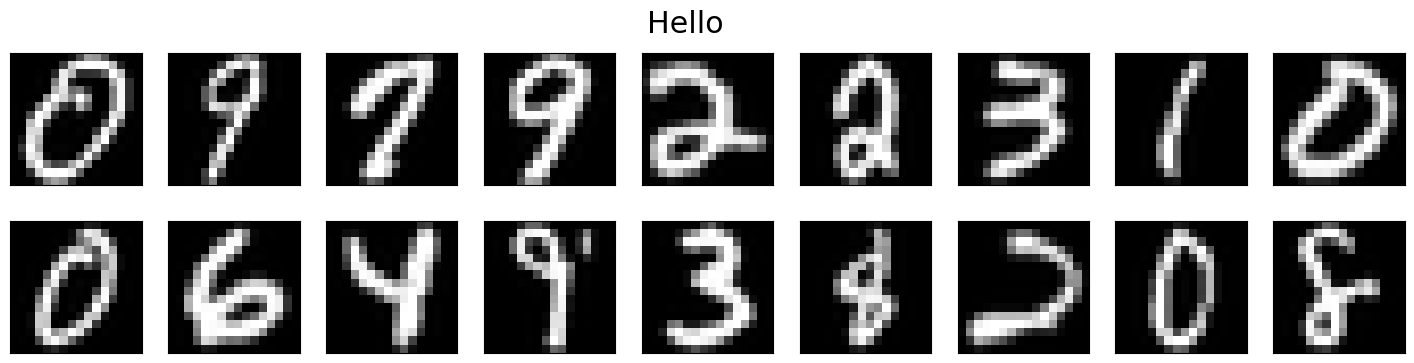

In [166]:
plot_images_16(test_data[:20].squeeze(), "Hello")

In [17]:
save = False
plot_dir = "demo"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

In [122]:
def plot_images_16(data, title, n_rows=2, n_cols=9, save=False, plot_dir="demo"):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i][j].imshow(data[i*n_cols +j].cpu().reshape(16, 16).T, cmap='gray', vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle(title)

In [6]:
# Either load the params from a yaml file or define them on the fly
if True:
    with open("params/mnist.yaml") as f:
            params = yaml.full_load(f)
else:
    pass

In [8]:
ModelClass, ParamClass = get_network_classes_by_name(params.get("network_type", "VanillaINN"))
# Create TrainableNetwork hyperparameters
params["training_params"]["network_params"] = ParamClass(**params.get("network_params", {}))
params["training_params"]["network_type"] = ModelClass
training_params = JointTrainableNetworkParams(**params["training_params"])
model = JointTrainableNetwork(training_params)
ret_dict = model.fit(logger_kwargs={"save_dir": "lightning_logs/", "name":params["name"]}) 

TypeError: Hparam 'joint_loss' is required to be of type `LossWeights`, but got `{'gaussian_ML': 1.0, 'reconstruction': 10.0}` of type `AttributeDict`.

In [29]:
ckpt_path = get_ckpt_path("mnist", 14, "last", ckpt_dir="lightning_logs")
while True:
    try:
        model = JointTrainableNetwork.load_from_checkpoint(ckpt_path)
        break
    except:
        pass
model.eval()
data = {}

tensor([0.1742])
tensor([0.4263])
Initializing Multilevel INN as convolutional
Initializing normalization...
Initializing Wavelet networks...
Initializing Detail networks...
[(5, 7, 7), (11, 7, 7)]
[(5,), (240,)]
Initializing Coarse network...
MultilevelINN(
  (module_list): ModuleList(
    (0): Flatten()
    (1): FixedLinearTransform()
    (2): Reshape()
    (3): Identity()
    (4): GraphINN(
      (module_list): ModuleList(
        (0): IRevNetDownsampling()
        (1-12): 12 x AllInOneBlock(
          (softplus): Softplus(beta=0.5, threshold=20.0)
          (subnet): Sequential(
            (0): ResidualBlock(
              (layers): ModuleList(
                (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
                (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (3): ReLU()
                (4): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
           

In [5]:
@torch.no_grad()
def plot_model(model):
    batch_size = model.hparams["batch_size"]
    device = model.device
    test_data = model.test_data[:100]
    print(test_data[0].shape)
    test_samples = test_data[0]
    
    print("encoding testdata...")
    z_test = torch.cat([
        model(batch.to(device), [])[0].cpu()
        for batch in test_samples.split(batch_size)
    ])

    data = {}
    data["test_x"] = test_samples.cpu().numpy()
    data["test_z"] = z_test.cpu().numpy()

    print("evaluate model...")
    print("reconstructing...")
    """
    latent = torch.zeros((50,784))
    latent[:,-5:] = torch.linspace(-4,4.5,50)
    """
    latent = z_test[:50].clone()
    #latent = torch.randn([50,784])
    latent[:, -5:] = torch.zeros([50,5])
    #data["test_z"] = latent.cpu().numpy()
    
    reconstruction = torch.cat([
        model(batch.to(device), [], rev=True)[0].cpu()
        for batch in latent.split(batch_size)
    ])
    """
    print("sampling...")
    z_sampled = torch.randn_like(z_test)
    x_sampled = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), c_test.split(batch_size))
    ])
    """
    plot_images_28(reconstruction, "Original", "subject_model", n_rows=5, n_cols=10)
    
    return data

In [32]:
@torch.no_grad()
def save_and_plot_data(rectangular_flow, name):
    train_samples = rectangular_flow.train_data[:][0]
    print(train_samples.shape)
    val_samples = rectangular_flow.val_data[:][0]
    print(val_samples.shape)
    test_samples = rectangular_flow.test_data[:][0]
    print(test_samples.shape)
    
    device = rectangular_flow.device
    batch_size = rectangular_flow.hparams.batch_size
    
    print("encoding traindata...")
    z_train = torch.cat([
        model(batch.to(device), [])[0].cpu()
        for batch in train_samples.split(batch_size)
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        model(batch.to(device), [])[0].cpu()
        for batch in val_samples.split(batch_size)
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        model(batch.to(device), [])[0].cpu()
        for batch in test_samples.split(batch_size)
    ])

    print("save data...")
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train[:,-5:].cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val[:,-5:].cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test[:,-5:].cpu().numpy()

    
    Path(f"../FFF/data/{name}/subject_model").mkdir(parents=True, exist_ok=True)
    fileName = f"../FFF/data/{name}/data"
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    shutil.copytree(sm_path, f"../FFF/data/{name}/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)
    return data["test_y"]

In [33]:
sm_path = "lightning_logs/mnist/version_14"
test_z = save_and_plot_data(model, "mnist_splitflow")

torch.Size([240000, 1, 28, 28])
torch.Size([5000, 1, 28, 28])
torch.Size([35000, 1, 28, 28])
encoding traindata...
encoding valdata...
encoding testdata...
save data...


torch.Size([100, 1, 28, 28])
encoding testdata...
evaluate model...
reconstructing...


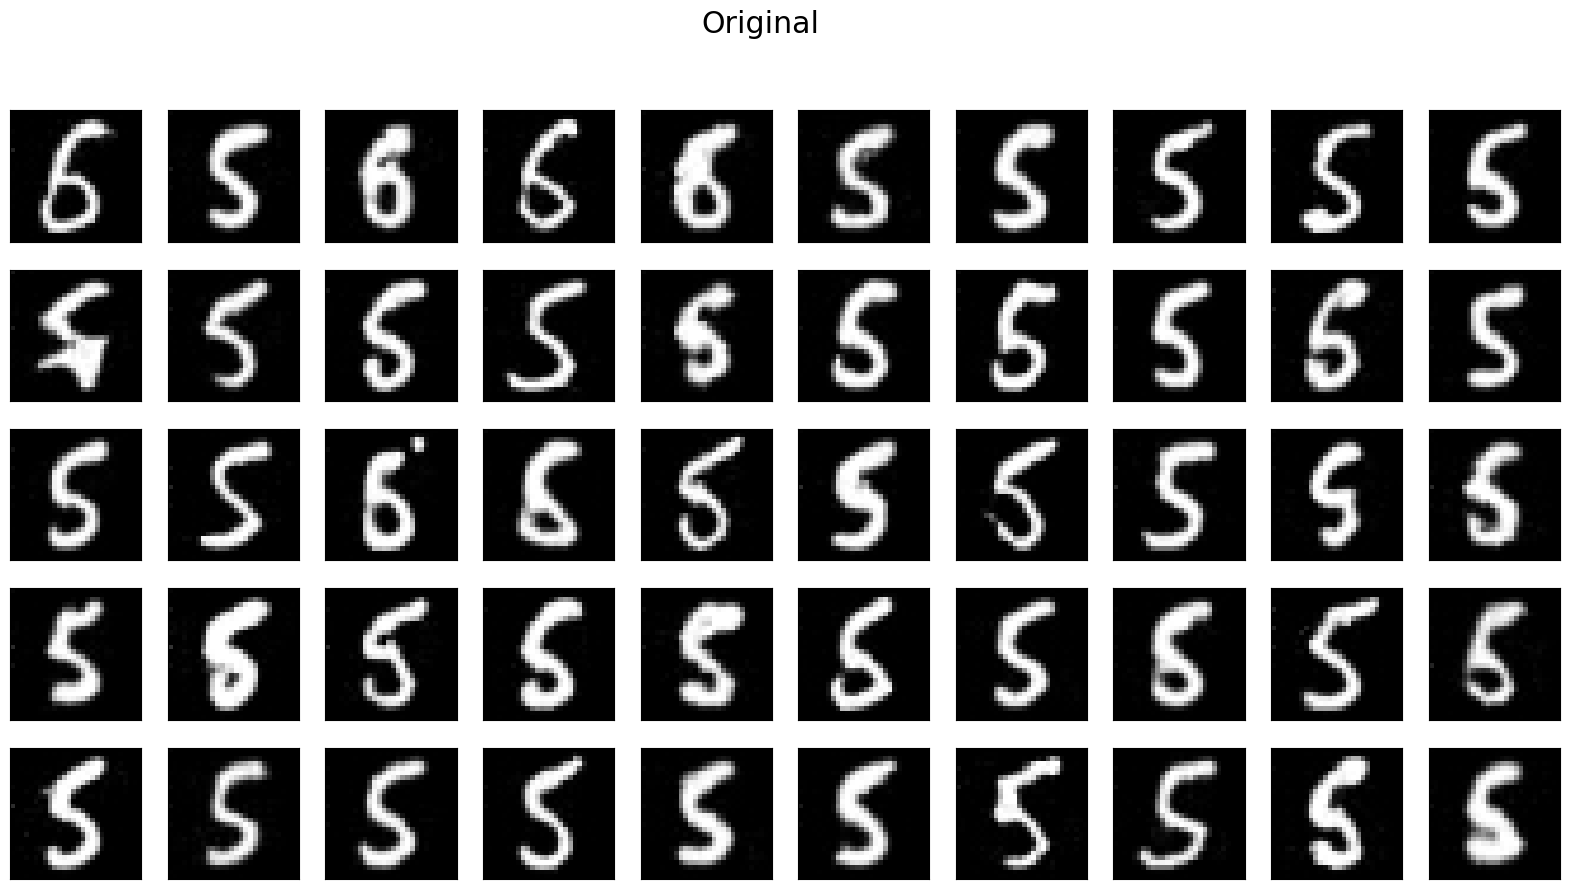

In [64]:
data = plot_model(model)

In [37]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

(35000, 784)


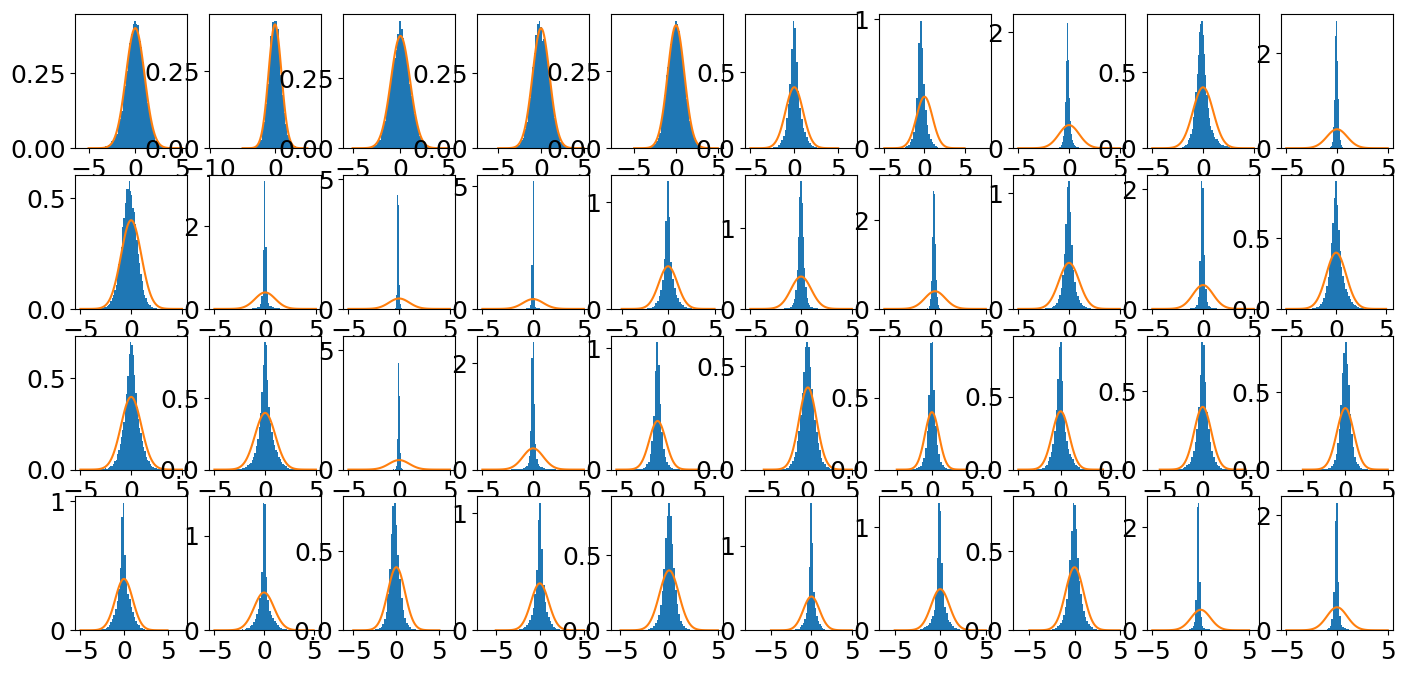

In [62]:
print(data["test_z"].shape)
z_plot = data["test_z"]
nrows = 4
ncols = 10
a = np.linspace(-5,5,100)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(17, nrows*2))
for i in range(nrows):
    for j in range(ncols):
        axes[i][j].hist(z_plot[:,-(i*ncols+j)-1], bins=60, label="Samples", density=True)
        axes[i][j].plot(a, normal(a))

In [45]:
print(model.network.get_latent_dimensions(concat=False))

(array([588, 191]), np.int64(5))


In [51]:
a = torch.zeros([2,10])
a[:, -5:] = 1
print(a)

tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
